# Exploratory data analysis

In this project, a database provided by Olist, a platform for online shopping is studied. This website, based in Brazil, sells all kinds of products. Olist provided a dataset of orders for investigating more in detail customer behaviors.

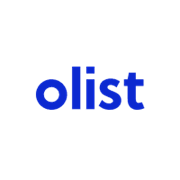

The aim of the project is to see if unsupervised machine learning allows classifying clients in order to adapt the communication of the company. Indeed, unsupervised machine learning algorithms allows identifying groups within a dataset (in such a structure exist). Identifying these groups could help understanding better the customers habits and behaviors. It is also a first step of feature engineering that could later allow the creation of a predictive model.

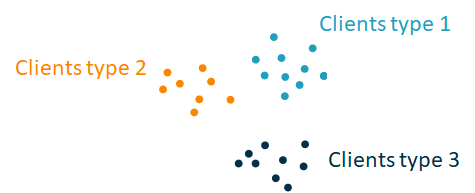

The data are coming from a database available on the platform Kaggle (<a href=https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce>see</a>). It contains 8 datasets from which information is linked with keys. The following figure explains how the different dataset is related

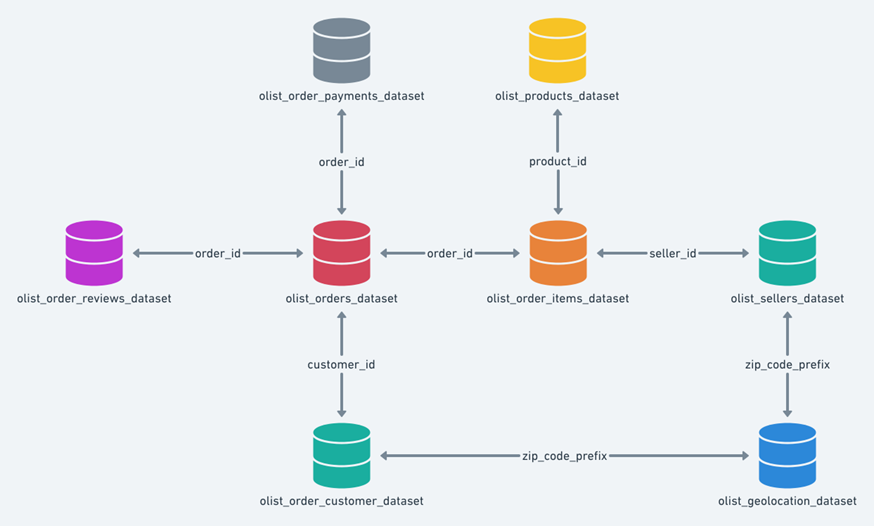

In a first step, data from the dataset have been aggregated in order to extract three main information : the Recency (date since last order), Frequency (total number of orders) and Monitary value (total amount spent) (RFM). The RFM model is a basic model used in marketing in order to classify customers’ behaviors (<a href=https://en.wikipedia.org/wiki/RFM_(market_research)>see<a/>). After assessing these simple features, more complex models have been studied as well.



In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import folium
import plotly.express as px

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

In [2]:
# Custom colors for charts

c_0 = np.array([2, 48, 71,256])/256
c_1 = np.array([251, 133, 0,256])/256
c_2 = np.array([255, 183, 3,256])/256
c_3 = np.array([33, 158, 188,256])/256
c_4 = np.array([142, 202, 230,256])/256

# Creating a custom colormap
# The code comes from https://matplotlib.org/3.1.1/tutorials/colors/colormap-manipulation.html
from matplotlib.colors import ListedColormap

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(c_0[0], c_1[0], N)
vals[:, 1] = np.linspace(c_0[1], c_1[1], N)
vals[:, 2] = np.linspace(c_0[2], c_1[2], N)
custom_cmp1 = ListedColormap(vals)

# A colormap with white in the middle
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.concatenate((np.linspace(c_0[0], 1, 128), np.linspace(1, c_1[0], 128)), axis = None)
vals[:, 1] = np.concatenate((np.linspace(c_0[1], 1, 128), np.linspace(1, c_1[1], 128)), axis = None)
vals[:, 2] = np.concatenate((np.linspace(c_0[2], 1, 128), np.linspace(1, c_1[2], 128)), axis = None)
custom_cmp2 = ListedColormap(vals)

# Allow value-dependant colorbar

def color_bar(y, cmap=custom_cmp1):
    
    # Create the matrix for colors
    color_list = []
    # Normalise the values
    y = (y-min(y))/(max(y)-min(y))
    
    for i in range(len(y)):
        color_list.append(cmap(int(N*y[i])))
    
    return color_list

# 1. Creating the aggregated dataset

The **datasets** are downloaded with the given names:

- olist_customers_dataset.csv
- olist_geolocation_dataset.csv
- olist_order_items_dataset.csv
- olist_order_payments_dataset.csv
- olist_order_reviews_dataset.csv
- olist_orders_dataset.csv
- olist_products_dataset.csv
- olist_sellers_dataset.csv
- product_category_name_translation.csv

In [3]:
df_customers = pd.read_csv('olist_customers_dataset.csv')
df_geolocation = pd.read_csv('olist_geolocation_dataset.csv')
df_items = pd.read_csv('olist_order_items_dataset.csv')
df_payments = pd.read_csv('olist_order_payments_dataset.csv')
df_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
df_orders = pd.read_csv('olist_orders_dataset.csv')
df_products = pd.read_csv('olist_products_dataset.csv')
df_sellers = pd.read_csv('olist_sellers_dataset.csv')
df_category = pd.read_csv('product_category_name_translation.csv')

# As the geolocation contains multiple duplicates, the data are grouped
df_geolocation_2 = df_geolocation.groupby('geolocation_zip_code_prefix').mean().reset_index()

# The category are translated

## The dataframe is converted to a dict to be mapped on the dataframe product
trans_dict = df_category.set_index('product_category_name').to_dict()['product_category_name_english']

df_products['product_category_name'] = df_products['product_category_name'].map(trans_dict)

The columns of each dataset are displayed to determine which contain relevant information

In [4]:
dataframe_list = [df_customers,
                  df_geolocation,
                  df_items,
                  df_payments,
                  df_reviews,
                  df_orders,
                  df_products,
                  df_sellers,
                  df_category]

for dataframe in dataframe_list:
    print(list(dataframe.columns))
    print('\n')

['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']


['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state']


['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']


['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']


['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']


['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']


['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']


['seller_id', 'seller_zip_code_prefix', 'sell

For obtaining the RFM, the data will be processed with the following method :

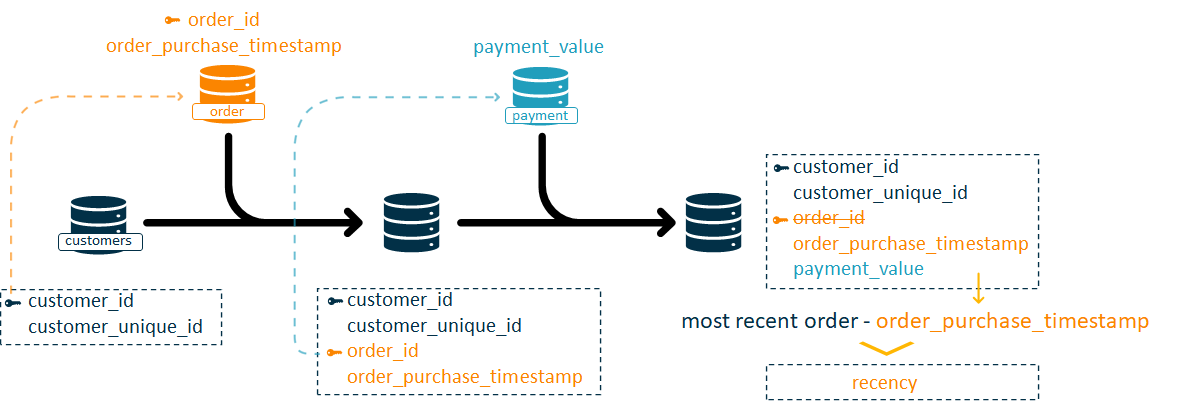

## 1.1 Aggregating the data

The data that are required for obtaining the RFM values are aggregated in one dataframe (df_raw). In the meantime, other features that could be interesting in customers’ behaviors segmentation are aggregated as well in the dataframe.

In [5]:
df_raw = df_customers[['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_state']]

**Recency**, **delivery_time** and **delay**

In [6]:
df_raw = pd.merge(df_raw,
                  df_orders[['customer_id', 'order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date']],
                  on = ['customer_id'])

**customer_satisfaction** and **customer_interaction**

In [7]:
df_raw = pd.merge(df_raw, pd.merge(df_orders[['customer_id', 'order_id']], # Merge df_raw with df_reviews through df_orders
                           df_reviews[['order_id', 'review_score', 'review_comment_message']],
                           on = 'order_id')[['customer_id', 'review_score', 'review_comment_message']],
                 
                 on = 'customer_id')

**product_volume_m3**, **density**, **preciousness** and **product_category_name**

In [8]:
df_raw = pd.merge(df_raw, pd.merge(df_orders[['customer_id', 'order_id']], # Merge df_raw with df_products through df_orders and d_items
                                   pd.merge(df_items[['order_id', 'product_id']],
                                            df_products[['product_id', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'product_category_name']],
                                            on = 'product_id'),
                           
                           on = 'order_id')[['customer_id', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'product_category_name']],
                 
                 on = 'customer_id')

**Monetary value** and **Frequency**

In [9]:
# Adding the modetary value from df_payments to df_orders to df_raw


df_raw = pd.merge(df_raw,
                  
                  pd.merge(df_orders[['customer_id', 'order_id']],
                           df_payments[['order_id','payment_value', 'payment_installments', 'payment_type']],
                           on = 'order_id')[['customer_id', 'payment_value', 'payment_installments', 'payment_type']],
                  
                  on = 'customer_id')

**product_distance_km**

In [10]:
# First we need customer geoloc
df_raw = pd.merge(df_raw,
                  df_geolocation_2,
                  left_on = 'customer_zip_code_prefix',
                  right_on = 'geolocation_zip_code_prefix')

df_raw = df_raw.rename(columns = {'geolocation_lat' : 'customer_geolocation_lat', 'geolocation_lng' : 'customer_geolocation_lng'}) # To avoid redundancy the cutomers location info is renamed

# Then we get seller geoloc

df_raw = pd.merge(df_raw, pd.merge(df_orders[['customer_id', 'order_id']], # Merge df_raw with df_sellers through df_orders and d_items
                                   pd.merge(df_items[['order_id', 'seller_id']],
                                            df_sellers[['seller_id', 'seller_zip_code_prefix']],
                                            on = 'seller_id'),
                           
                           on = 'order_id')[['customer_id', 'seller_zip_code_prefix']],
                 
                 on = 'customer_id')

df_raw = df_raw.drop(['geolocation_zip_code_prefix'] , axis = 1) # To avoid redundancy

df_raw = pd.merge(df_raw,
                  df_geolocation_2,
                  left_on = 'seller_zip_code_prefix',
                  right_on = 'geolocation_zip_code_prefix')

df_raw = df_raw.rename(columns ={'geolocation_lat' : 'seller_geolocation_lat', 'geolocation_lng' : 'seller_geolocation_lng'}) # To avoid redundancy the seller location info is renamed

## 1.2 Calculations

Some features are not directly provided in the datasets and should be calculated.

**Recency**, **delivery_time** and **delay**

In [11]:
# Convert to datetime
for date in ['order_purchase_timestamp','order_delivered_customer_date', 'order_estimated_delivery_date']:
    df_raw[date] = pd.to_datetime(df_raw[date])

# Recency
## Set the most recent as d0
most_recent = df_raw['order_purchase_timestamp'].max()

## Calculate the number of days from the most recent
df_raw['recency'] = (most_recent - df_raw['order_purchase_timestamp']).dt.days # .dt.days convert datime to nb of days


# delivery time
df_raw['delivery_time'] = (df_raw['order_estimated_delivery_date'] - df_raw['order_purchase_timestamp']).dt.days

# delay
df_raw['delay'] = (df_raw['order_delivered_customer_date'] - df_raw['order_estimated_delivery_date']).dt.days


**product_volume_m3**, **density** and **preciousness**

In [12]:
df_raw['product_volume_m3'] = df_raw['product_length_cm'] * df_raw['product_height_cm'] * df_raw['product_width_cm']


# For calculating divisions, making sure that no value equal to 0

print(df_raw[df_raw['product_volume_m3'] == 0].shape)

print(df_raw[df_raw['payment_value'] == 0].shape)

(0, 27)
(6, 27)


In [13]:
# 6 orders with a value of 0 are droped

df_raw = df_raw.drop(df_raw[df_raw['payment_value'] == 0].index, axis = 0)

In [14]:
df_raw['product_volume_m3'] = df_raw['product_length_cm'] * df_raw['product_height_cm'] * df_raw['product_width_cm']

df_raw['density'] = df_raw['product_weight_g'] / df_raw['product_volume_m3']

df_raw['preciousness'] = df_raw['product_weight_g'] / df_raw['payment_value']

**product_distance_km**

In [15]:
# This function comes from a previous project and have been provided by IBM through the
# Program 'Python Data Science' https://www.edx.org/professional-certificate/ibm-python-data-science

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance

df_raw['product_distance_km'] = calculate_distance(df_raw['customer_geolocation_lat'], df_raw['customer_geolocation_lng'],
                                                   df_raw['seller_geolocation_lat'], df_raw['seller_geolocation_lng'])


In [16]:
# All the data used for calculation but not interresting for the clustering are droped
# Look here for adding new data for clustering

df_raw = df_raw.drop(labels = ['customer_geolocation_lat',
                               'customer_geolocation_lng',
                               'seller_geolocation_lat',
                               'seller_geolocation_lng',
                               'order_delivered_customer_date',
                               'order_estimated_delivery_date',
                               'product_length_cm',
                               'product_height_cm',
                               'product_width_cm',
                               'geolocation_zip_code_prefix'
                               ], axis = 1)

## 1.3 Encoding categories

The products purshased by the customers are classified into categories. The categories are words and thus can not be processed by the machine learning algorithms. It should be encoded in numerical values. This would also allow todetermine how many articles from a given given category were bought. However, the number of categories very high (70) could result in a sparse dataset. Thus categories will be grouped into subcatergories.

In [17]:
# Then the number of categories is reduced
df_products['product_category_name'].nunique()

71

In [18]:
# The subcategories have been stored in a csv file and are imported
df_subcategories = pd.read_csv('Categories.csv', sep = '\t', names = ['subcategory', 'cat_list'], index_col =0)
df_subcategories['cat_list'] = df_subcategories['cat_list'].str.split(',')
df_subcategories.head()

cat_list
subcategory                                                    
professional  [office_furniture, agro_industry_and_commerce,...
electronics   [computers_accessories, electronics, telephony...
food_drinks                          [food_drink, food, drinks]
healthcare           [baby, health_beauty, diapers_and_hygiene]
art                                [art, arts_and_craftmanship]

In [19]:
# The categories are added as features to the dataframe
for cat in df_subcategories.index:
    df_raw[cat] = np.zeros((df_raw.shape[0],))

# A +1 is added for each product wich belong to a given subcategory

for index, row in df_raw.iterrows():
    for cat in df_subcategories.index:
        if row['product_category_name'] in df_subcategories.loc[cat, 'cat_list']:
            df_raw.loc[index, cat] = 1

In [20]:
# Finaly categories are droped
df_raw = df_raw.drop('product_category_name', axis = 1)


## 1.4 Grouping order by customers

All the samples in the current dataframe (df_raw) corresponds to individual orders. However, some customers have done multiple orders. The orders should then be grouped by customers. This grouping allows calculating the RFM features.

In [21]:
list(df_raw.columns)

['customer_id',
 'customer_unique_id',
 'customer_zip_code_prefix',
 'customer_state',
 'order_purchase_timestamp',
 'review_score',
 'review_comment_message',
 'product_weight_g',
 'payment_value',
 'payment_installments',
 'payment_type',
 'seller_zip_code_prefix',
 'recency',
 'delivery_time',
 'delay',
 'product_volume_m3',
 'density',
 'preciousness',
 'product_distance_km',
 'professional',
 'electronics',
 'food_drinks',
 'healthcare',
 'art',
 'multimedia',
 'books',
 'construction',
 'garden',
 'auto',
 'divers_gifts',
 'sport',
 'clothing',
 'small_housewares',
 'large_housewares',
 'other']

In [22]:
## Calculating values min, max, sum, mean or mode through the aggregation process
## A dict is create for the categories features so they are summed


df_raw = df_raw.groupby('customer_unique_id').agg({'customer_state': pd.Series.mode,
                                                  'customer_zip_code_prefix': pd.Series.mode,
                                                  'order_purchase_timestamp': ['min', 'max'],
                                                  'review_score': 'mean',
                                                  'review_comment_message': 'count',
                                                  'product_weight_g': 'mean',
                                                  'payment_value': ['sum', 'mean'],
                                                  'payment_installments': 'mean',
                                                  'payment_type': pd.Series.mode,
                                                  'seller_zip_code_prefix': pd.Series.mode,
                                                  'recency': 'min',
                                                  'delivery_time': 'max',
                                                  'delay': 'max',
                                                  'product_volume_m3': 'mean',
                                                  'density': 'mean',
                                                  'preciousness': 'mean',
                                                  'product_distance_km': 'mean',
                                                  'customer_id': 'count'} | {cat : 'sum' for cat in df_subcategories.index})



In [23]:
# Then columns are renamed
df_raw.columns = ['customer_state',
                'customer_zip',
                'timestamp_min',
                'timestamp_max',
                'review_score_mean',
                'review_message_count',
                'weight_mean',
                'value_total',
                'value_mean',
                'installments_mean',
                'payment_type',
                'seller_zip',
                'recency',
                'delivery_time',
                'delay',
                'volume_mean',
                'density',
                'preciousness',
                'distance',
                'frequency',
                'professional',
                'electronics',
                'food_drinks',
                'healthcare',
                'art',
                'multimedia',
                'books',
                'construction',
                'garden',
                'auto',
                'divers_gifts',
                'sport',
                'clothing',
                'small_housewares',
                'large_housewares',
                'other']

**Seniority**

In [24]:
df_raw['seniority'] = (df_raw['timestamp_max'] - df_raw['timestamp_min'])
df_raw = df_raw.drop(['timestamp_max', 'timestamp_min'], axis = 1)

In [25]:
df_raw['seniority'] = df_raw['seniority'].dt.days

**Adding main category**

For easy classification of the customer main purchase, the main prodcut category is added as feature.

In [26]:
df_raw['main_category'] = df_raw[df_subcategories.index].idxmax(axis = 1)

In [27]:
df_raw.head()

customer_state customer_zip  \
customer_unique_id                                             
0000366f3b9a7992bf8c76cfdf3221e2             SP         7787   
0000b849f77a49e4a4ce2b2a4ca5be3f             SP         6053   
0000f46a3911fa3c0805444483337064             SC        88115   
0000f6ccb0745a6a4b88665a16c9f078             PA        66812   
0004aac84e0df4da2b147fca70cf8255             SP        18040   

                                  review_score_mean  review_message_count  \
customer_unique_id                                                          
0000366f3b9a7992bf8c76cfdf3221e2                5.0                     1   
0000b849f77a49e4a4ce2b2a4ca5be3f                4.0                     0   
0000f46a3911fa3c0805444483337064                3.0                     0   
0000f6ccb0745a6a4b88665a16c9f078                4.0                     1   
0004aac84e0df4da2b147fca70cf8255                5.0                     0   

                                  weight_mean  value_total  value_mean  \
customer_unique_id                                                       
0000366f3b9a7992bf8c76cfdf3221e2       1500.0       141.90      141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f        375.0        27.19       27.19   
0000f46a3911fa3c0805444483337064       1500.0        86.22       86.22   
0000f6ccb0745a6a4b88665a16c9f078        150.0        43.62       43.62   
0004aac84e0df4da2b147fca70cf8255       6050.0       196.89      196.89   

                                  installments_mean payment_type seller_zip  \
customer_unique_id                                                            
0000366f3b9a7992bf8c76cfdf3221e2                8.0  credit_card      13405   
0000b849f77a49e4a4ce2b2a4ca5be3f                1.0  credit_card       2215   
0000f46a3911fa3c0805444483337064                8.0  credit_card      13232   
0000f6ccb0745a6a4b88665a16c9f078                4.0  credit_card       3569   
0004aac84e0df4da2b147fca70cf8255                6.0  credit_card      12327   

                                  ...  garden  auto  divers_gifts  sport  \
customer_unique_id                ...                                      
0000366f3b9a7992bf8c76cfdf3221e2  ...     0.0   0.0           0.0    0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f  ...     0.0   0.0           0.0    0.0   
0000f46a3911fa3c0805444483337064  ...     0.0   0.0           0.0    0.0   
0000f6ccb0745a6a4b88665a16c9f078  ...     0.0   0.0           0.0    0.0   
0004aac84e0df4da2b147fca70cf8255  ...     0.0   0.0           0.0    0.0   

                                  clothing  small_housewares  \
customer_unique_id                                             
0000366f3b9a7992bf8c76cfdf3221e2       0.0               1.0   
0000b849f77a49e4a4ce2b2a4ca5be3f       0.0               0.0   
0000f46a3911fa3c0805444483337064       0.0               0.0   
0000f6ccb0745a6a4b88665a16c9f078       0.0               0.0   
0004aac84e0df4da2b147fca70cf8255       0.0               0.0   

                                  large_housewares  other  seniority  \
customer_unique_id                                                     
0000366f3b9a7992bf8c76cfdf3221e2               0.0    0.0          0   
0000b849f77a49e4a4ce2b2a4ca5be3f               0.0    0.0          0   
0000f46a3911fa3c0805444483337064               0.0    0.0          0   
0000f6ccb0745a6a4b88665a16c9f078               0.0    0.0          0   
0004aac84e0df4da2b147fca70cf8255               0.0    0.0          0   

                                     main_category  
customer_unique_id                                  
0000366f3b9a7992bf8c76cfdf3221e2  small_housewares  
0000b849f77a49e4a4ce2b2a4ca5be3f        healthcare  
0000f46a3911fa3c0805444483337064      professional  
0000f6ccb0745a6a4b88665a16c9f078       electronics  
0004aac84e0df4da2b147fca70cf8255       electronics  

[5 rows x 36 columns]

# 2. Cleaning the dataset

Now that the data have been aggregated and merged by customers is a single dataset, this dataset can be cleaned in order to get ride of duplicates, missing values and outliers that could hinder the unsupervised classification.

In [28]:
# First a cleaned dataset is created :
df = df_raw.copy()

## 2.1 Duplicates

In [29]:
# Looking at duplicates
df.index.duplicated().sum()

0

It appears that there are no duplicates.

## 2.2 Missing values

In [30]:
# Looking for missing values

df.isna().sum(axis = 0)

customer_state             0
customer_zip               0
review_score_mean          0
review_message_count       0
weight_mean               13
value_total                0
value_mean                 0
installments_mean          0
payment_type               0
seller_zip                 0
recency                    0
delivery_time              0
delay                   1956
volume_mean               13
density                   13
preciousness              13
distance                   0
frequency                  0
professional               0
electronics                0
food_drinks                0
healthcare                 0
art                        0
multimedia                 0
books                      0
construction               0
garden                     0
auto                       0
divers_gifts               0
sport                      0
clothing                   0
small_housewares           0
large_housewares           0
other                      0
seniority     

<AxesSubplot:>

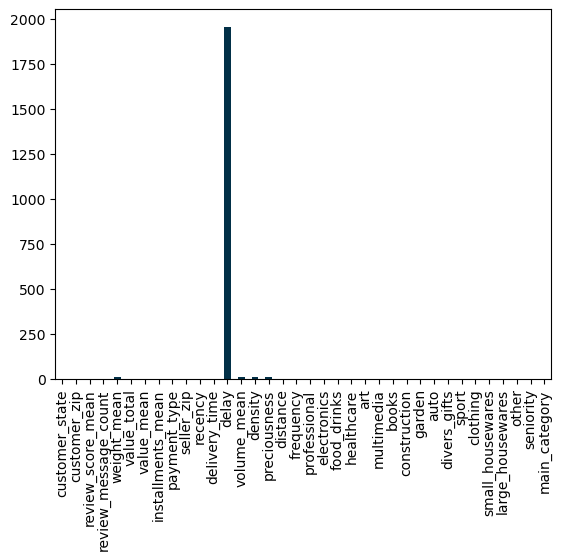

In [31]:
df.isna().sum(axis = 0).plot(kind = 'bar', color = c_0)

In [32]:
# For categories, customer with articles belonging to no categories are droped
df = df.drop(df[df[df_subcategories.index].sum(axis = 1)==0].index)

The missing *delay_max* can probably be imputed. Thus, correlation with other features are studied.

In [33]:
df.corr().loc['delay']

review_score_mean      -0.267581
review_message_count   -0.002544
weight_mean             0.010588
value_total            -0.002613
value_mean             -0.018437
installments_mean      -0.027695
recency                -0.099444
delivery_time          -0.485708
delay                   1.000000
volume_mean             0.010992
density                 0.005181
preciousness           -0.001689
distance               -0.074808
frequency              -0.008210
professional           -0.000686
electronics             0.002509
food_drinks             0.001506
healthcare              0.002661
art                    -0.002787
multimedia              0.000090
books                  -0.000621
construction           -0.002223
garden                 -0.002640
auto                    0.000341
divers_gifts           -0.005849
sport                  -0.005853
clothing               -0.009681
small_housewares       -0.002047
large_housewares       -0.006944
other                  -0.013460
seniority 

There is an interresting correlation of the *delay_max* with *delivery_time_max* 

In [34]:
df['delay'] = IterativeImputer().fit_transform(df[['delay', 'delivery_time']])[:,0]

As there are only 13 missing values, the corresponding samples are droped.

In [36]:
df = df.drop(df[df['weight_mean'].isna()].index, axis = 0)

In [37]:
# Checking there is no more missing values

df.isna().sum(axis = 0)

customer_state          0
customer_zip            0
review_score_mean       0
review_message_count    0
weight_mean             0
value_total             0
value_mean              0
installments_mean       0
payment_type            0
seller_zip              0
recency                 0
delivery_time           0
delay                   0
volume_mean             0
density                 0
preciousness            0
distance                0
frequency               0
professional            0
electronics             0
food_drinks             0
healthcare              0
art                     0
multimedia              0
books                   0
construction            0
garden                  0
auto                    0
divers_gifts            0
sport                   0
clothing                0
small_housewares        0
large_housewares        0
other                   0
seniority               0
main_category           0
dtype: int64

No missing values are left.

## 2.3 Outliers

Then **outliers** are addressed

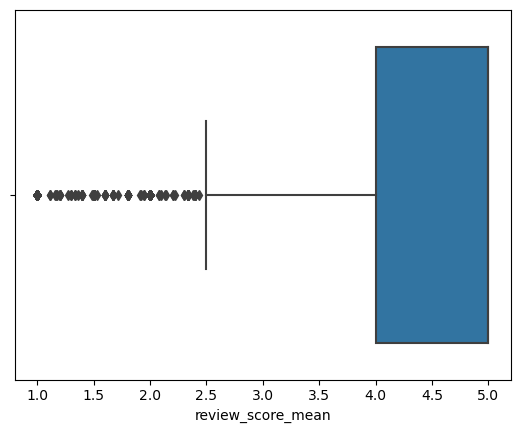

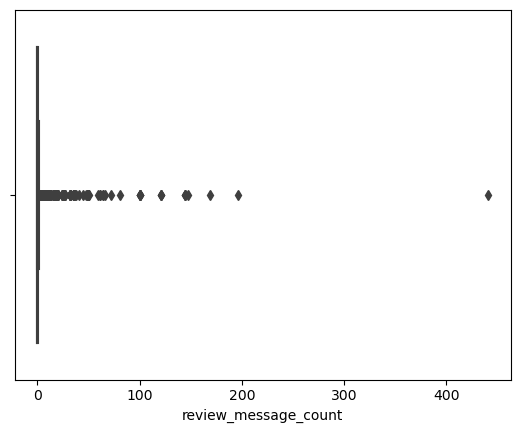

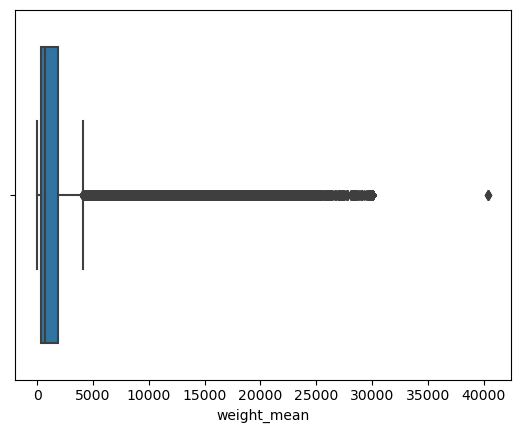

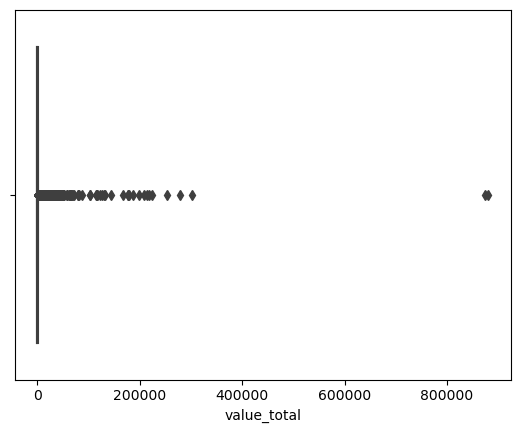

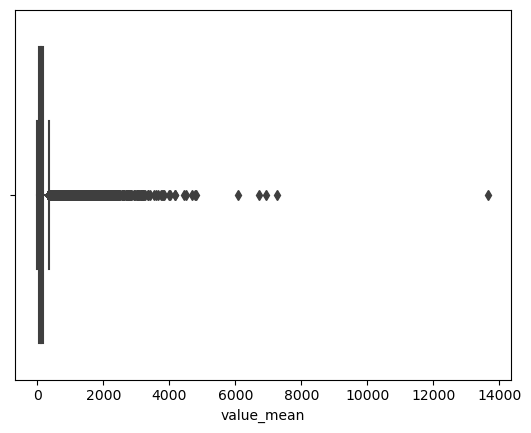

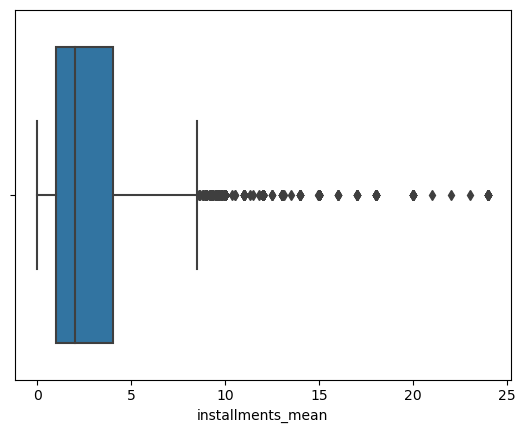

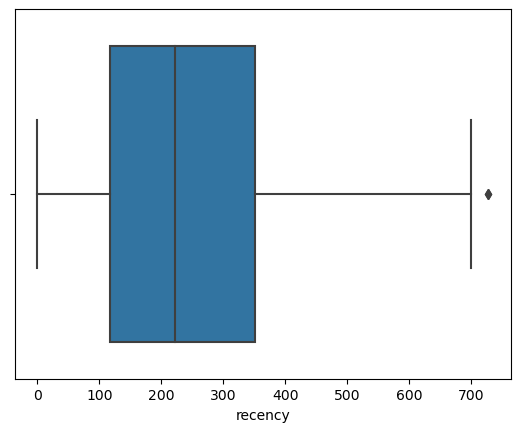

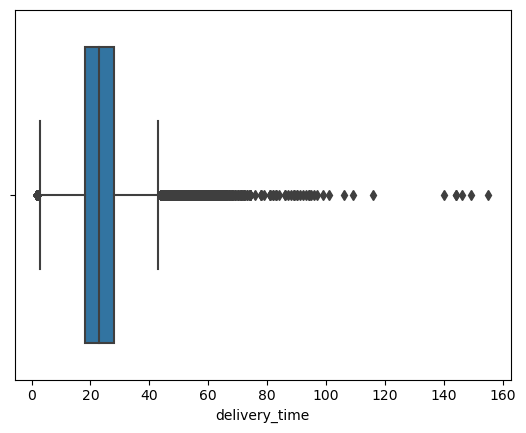

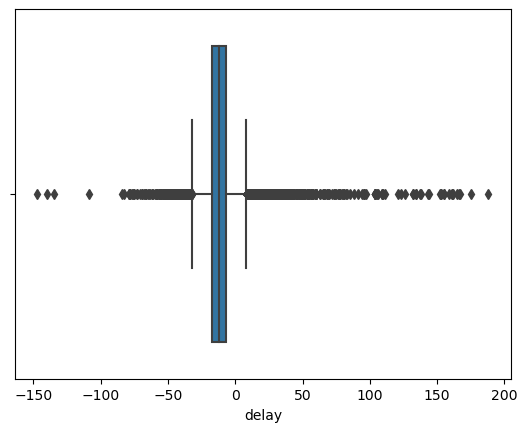

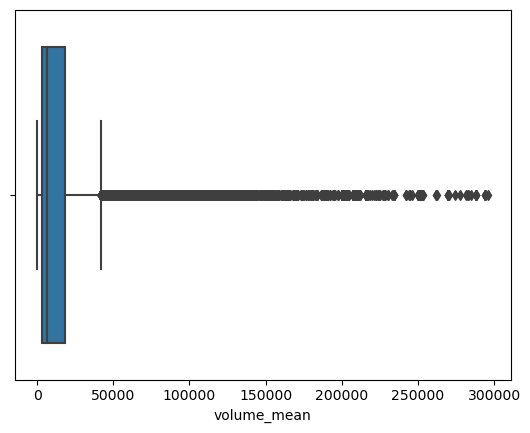

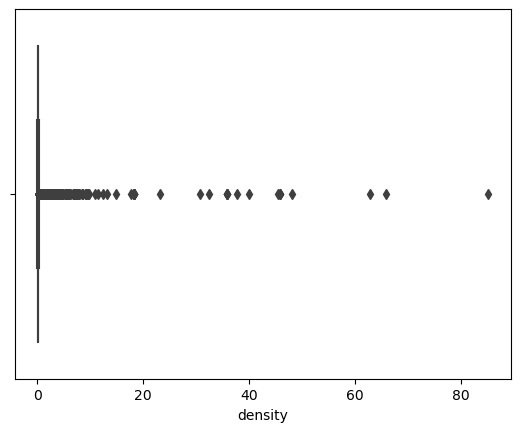

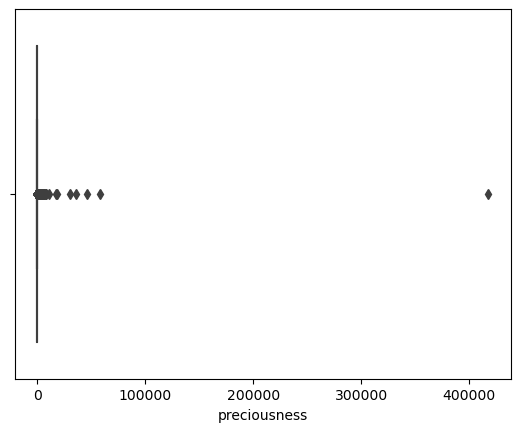

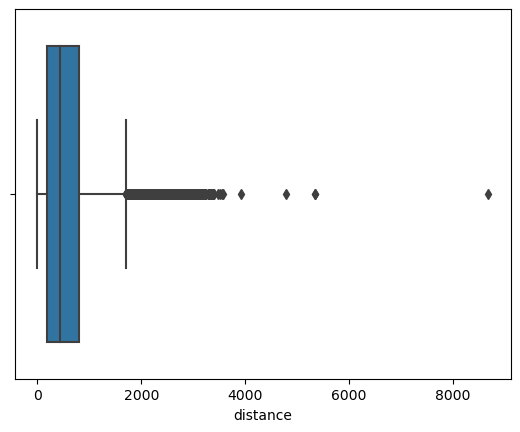

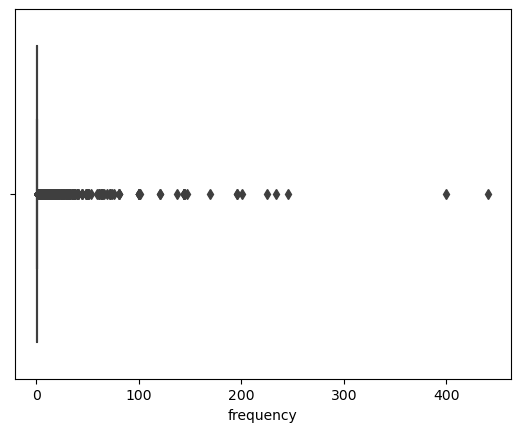

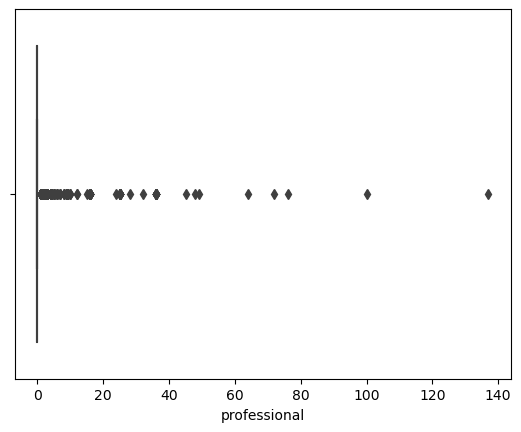

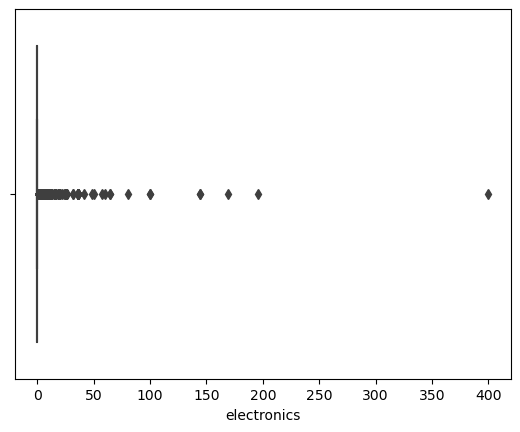

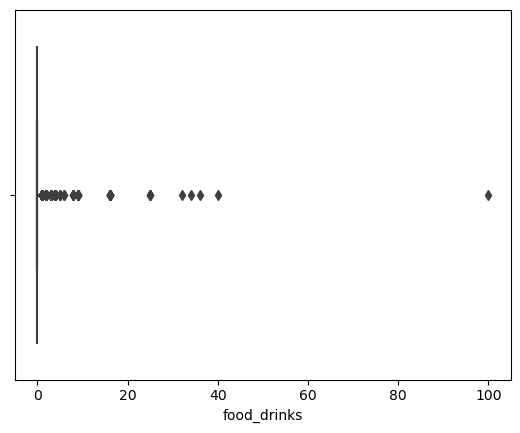

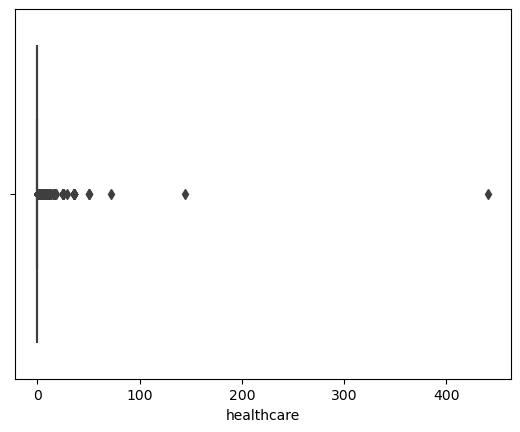

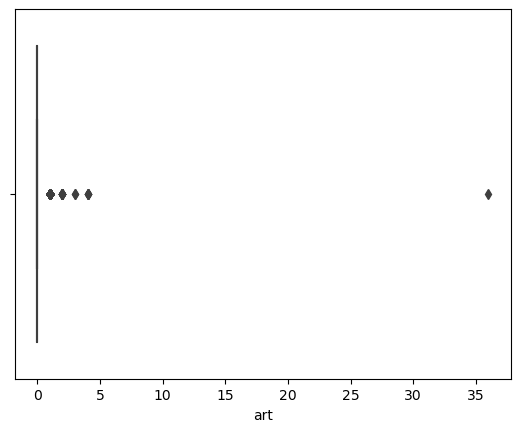

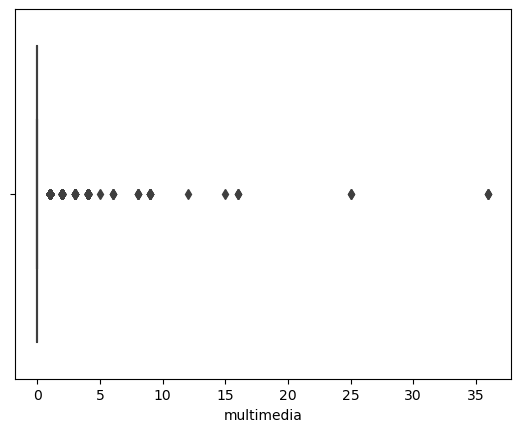

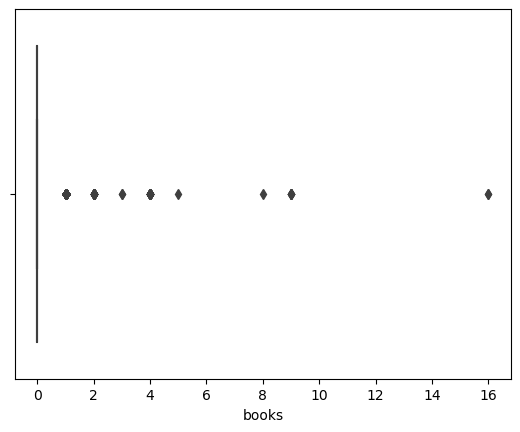

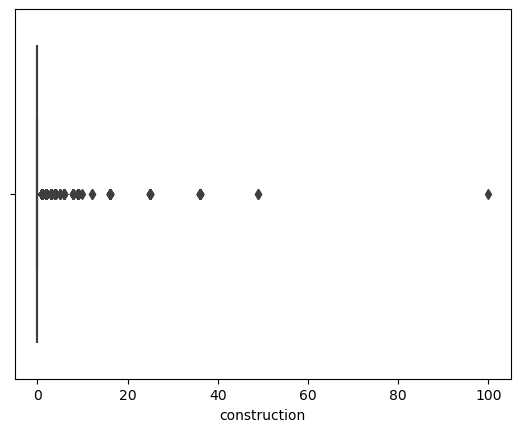

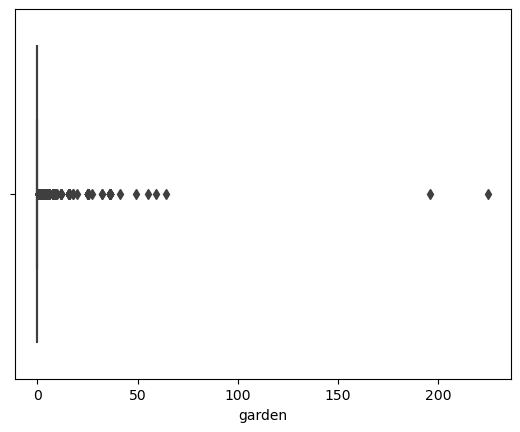

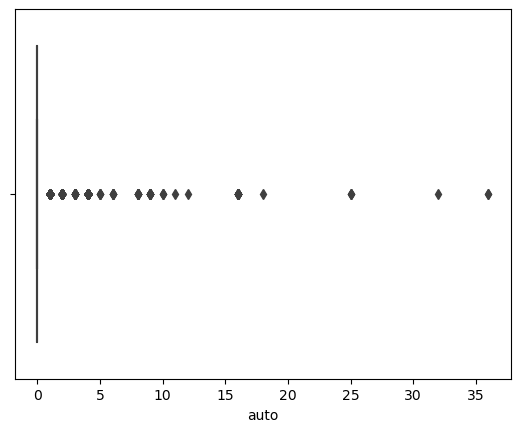

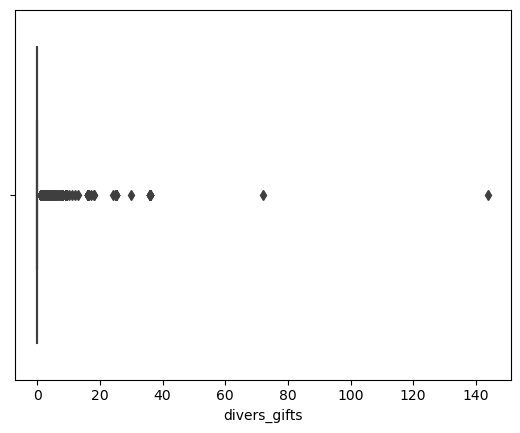

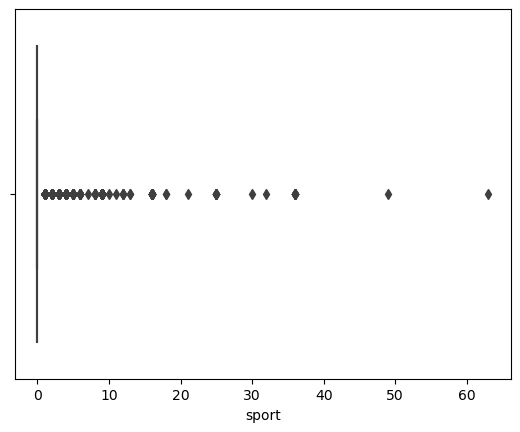

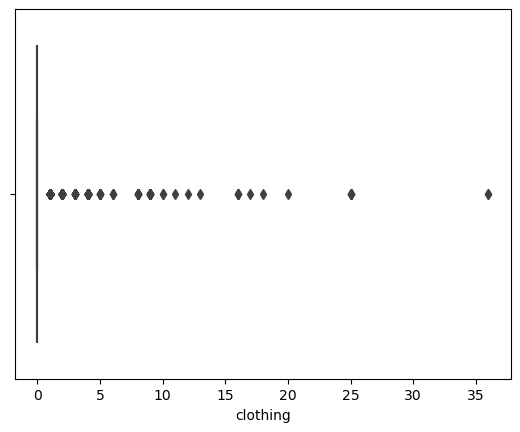

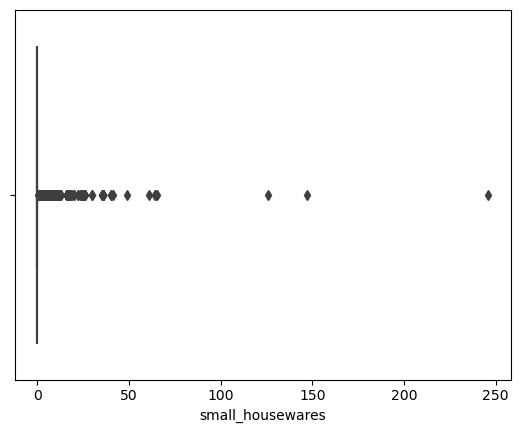

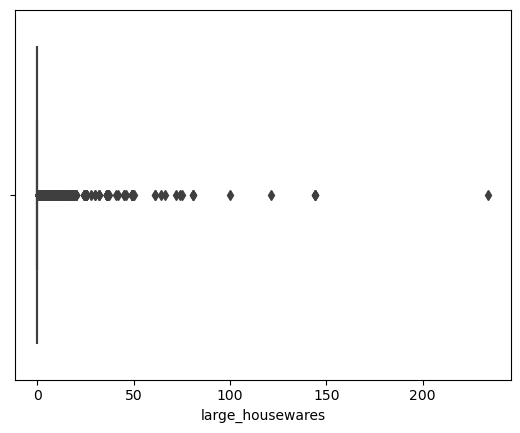

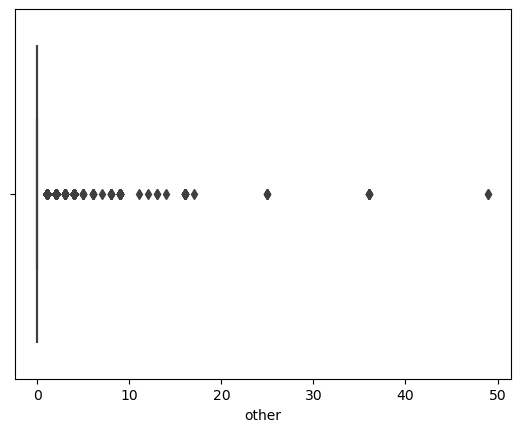

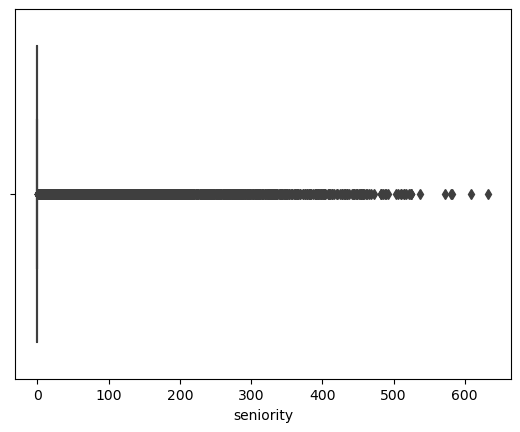

In [38]:
# Looking for outliers

for col in df.select_dtypes(exclude = 'O'):
    sns.boxplot(data = df, x = col)
    plt.show()

It appears that there are clear outliers in review_message_count, weight_mean, value_total, preciousness_mean and distance_mean and frequency. These outliers are simply adressed by setting a threshold.

In [39]:
# There is clear outliers in review_message_count, weight_mean, value_total, preciousness_mean and distance_mean and frequency

df = df.drop(df[df['review_message_count'] > 300].index)
df = df.drop(df[df['weight_mean'] > 35000].index)
df = df.drop(df[df['value_total'] > 400000].index)
df = df.drop(df[df['preciousness'] > 100000].index)
df = df.drop(df[df['distance'] > 6000].index)
df = df.drop(df[df['frequency'] > 300].index)

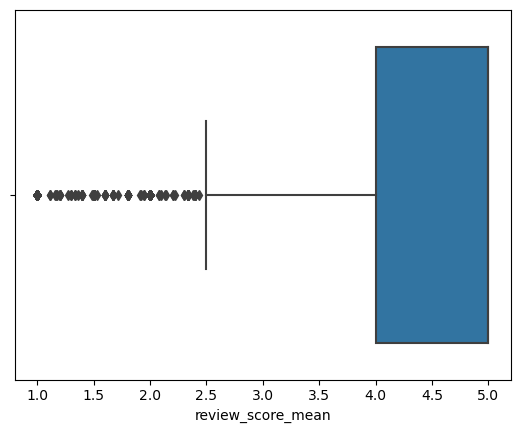

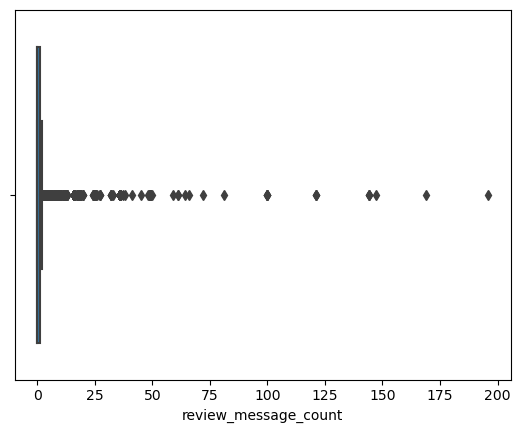

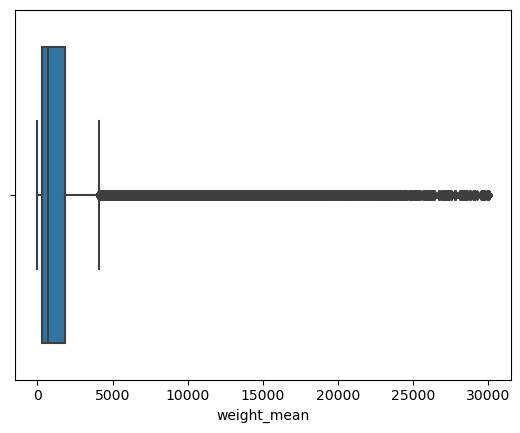

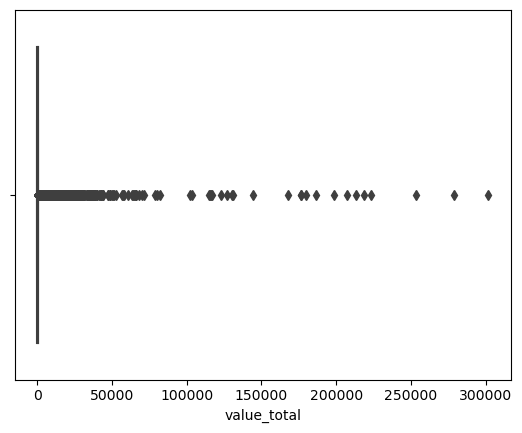

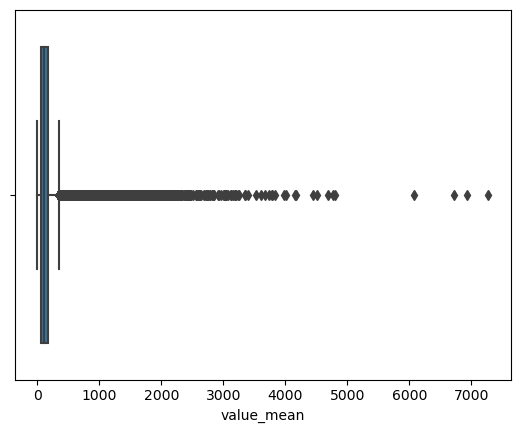

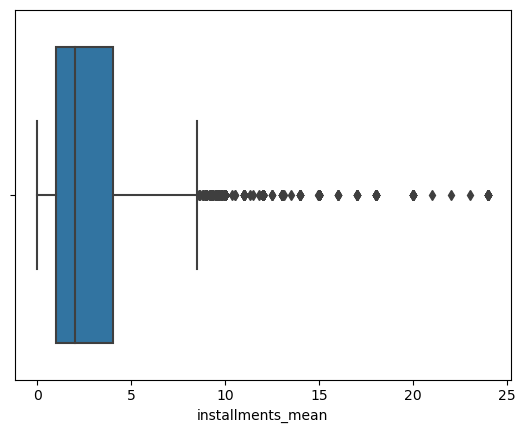

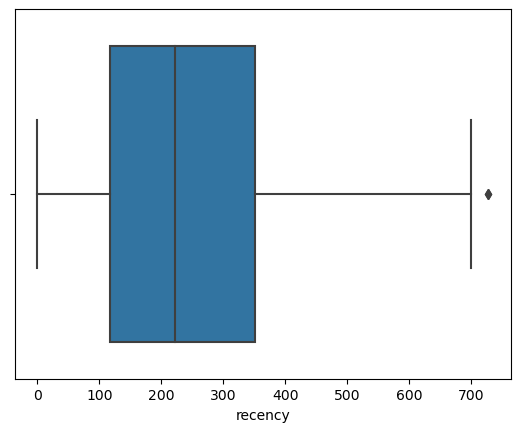

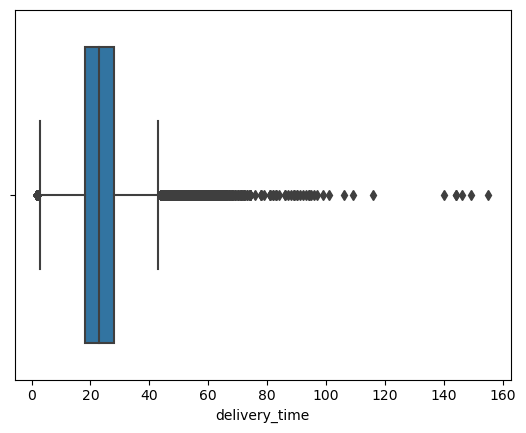

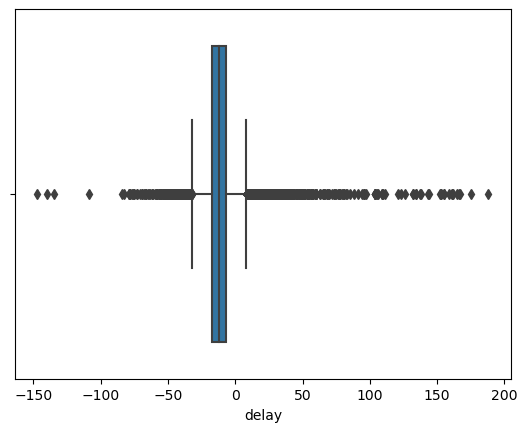

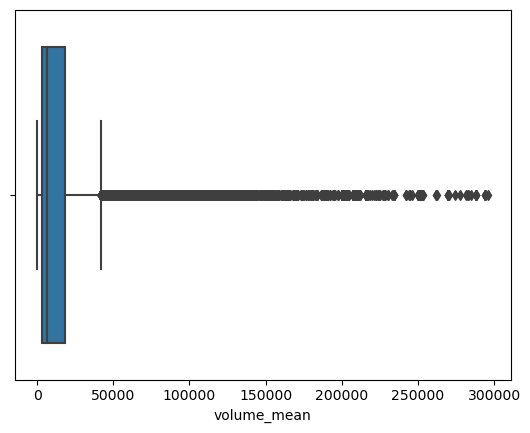

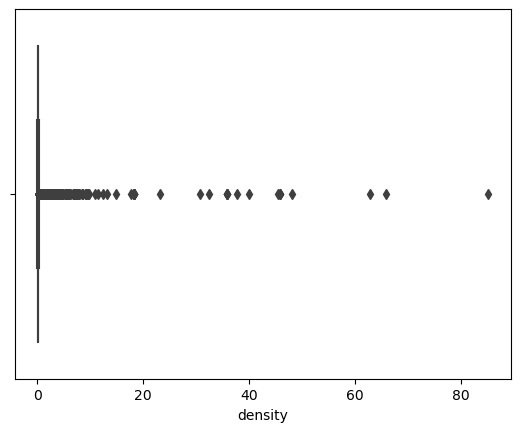

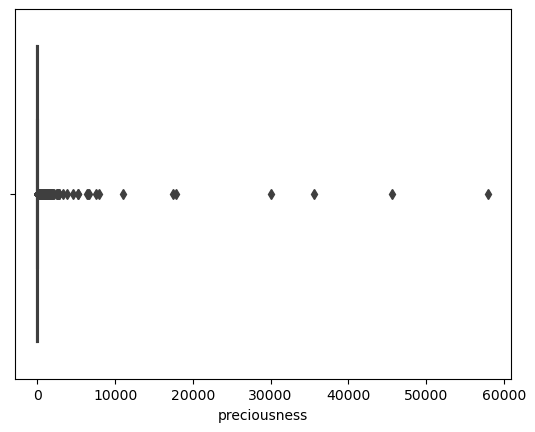

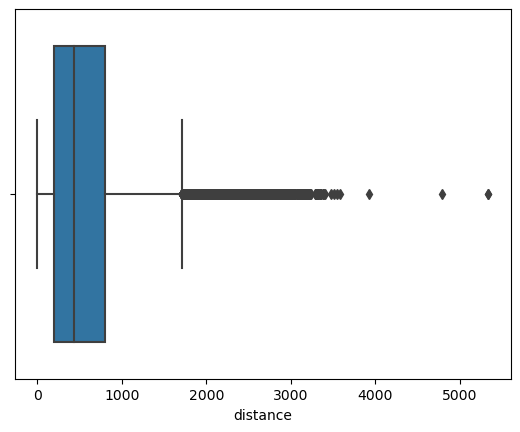

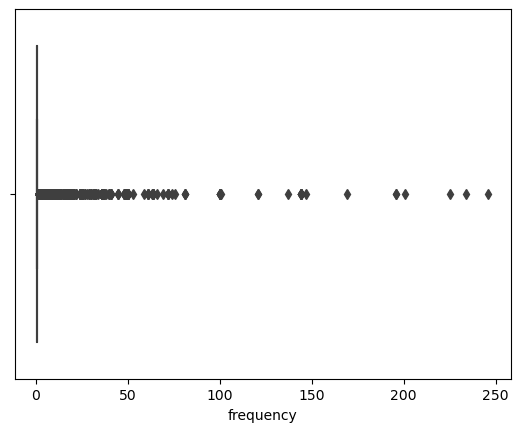

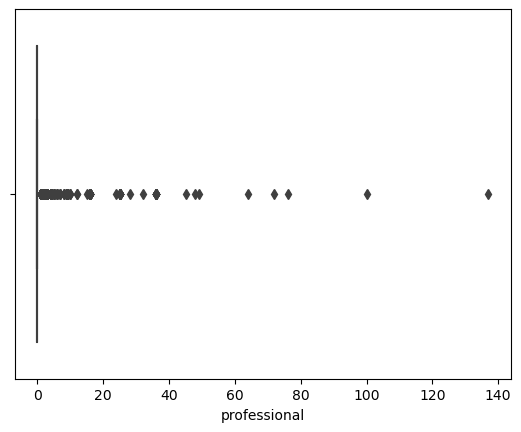

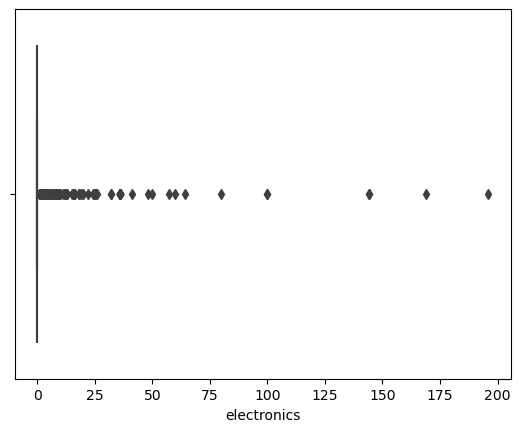

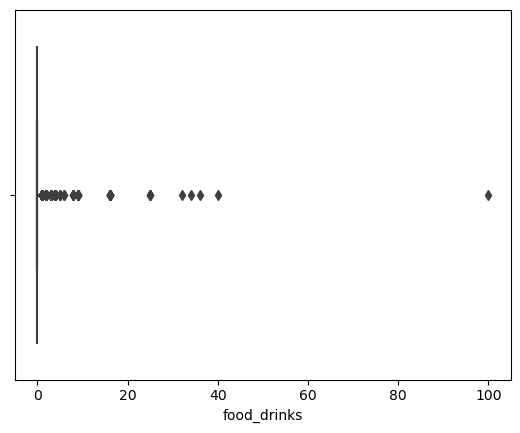

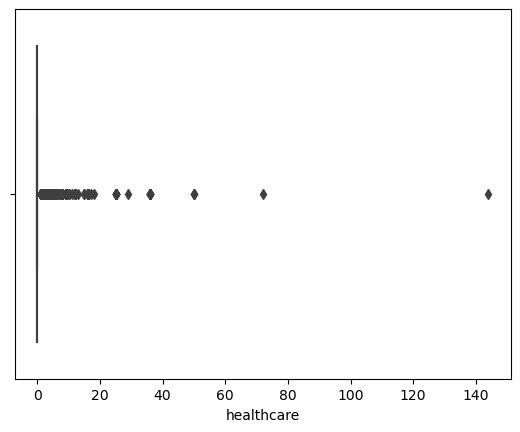

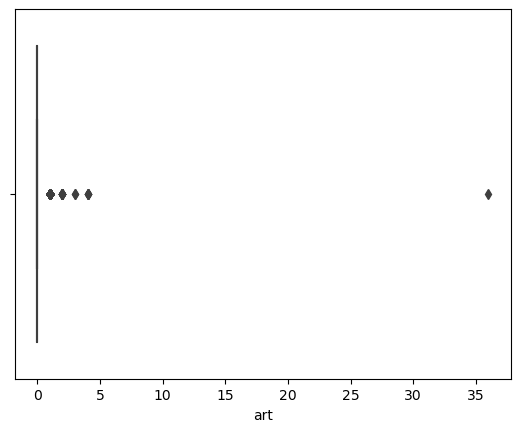

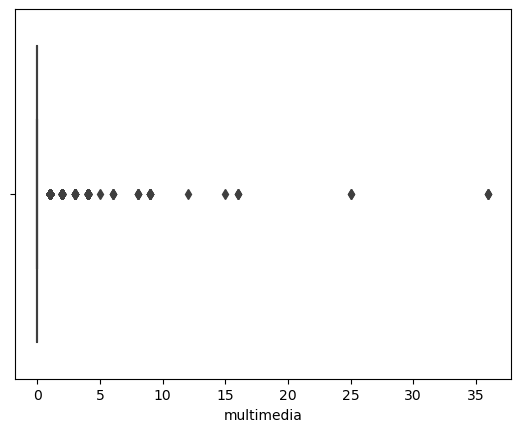

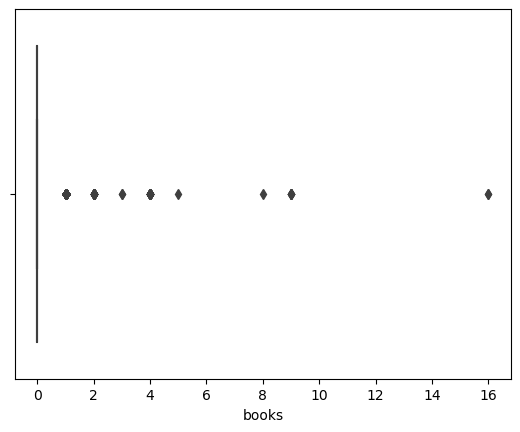

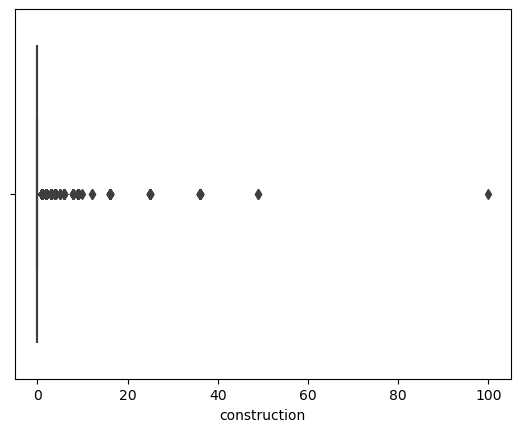

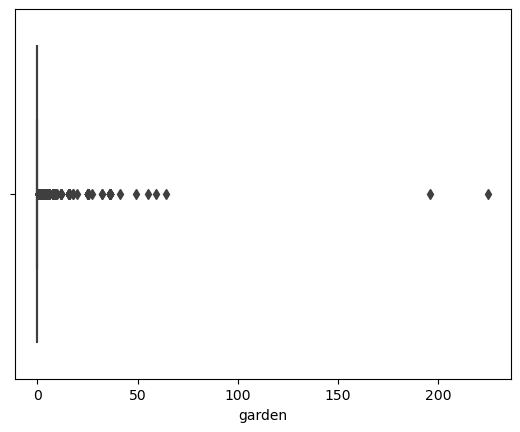

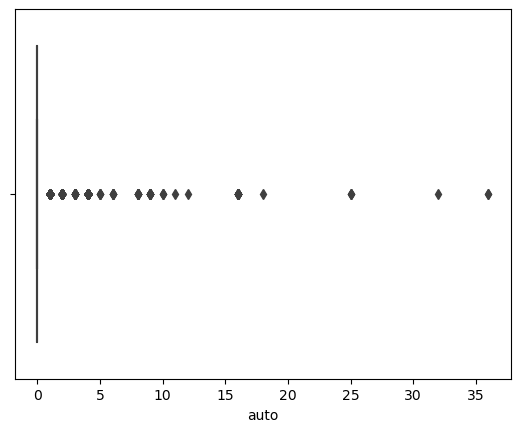

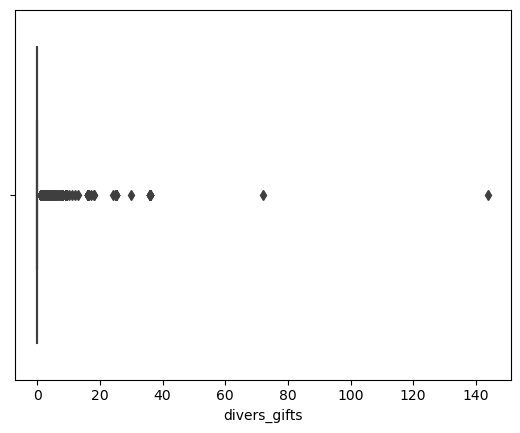

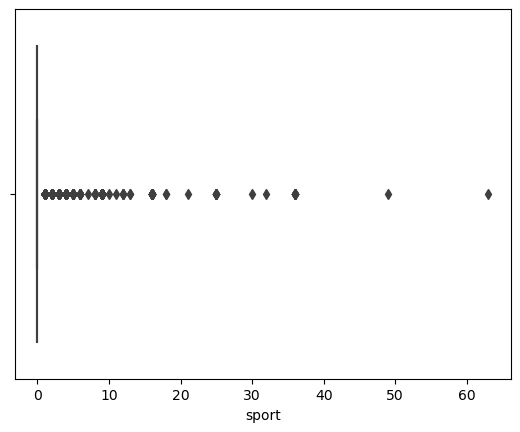

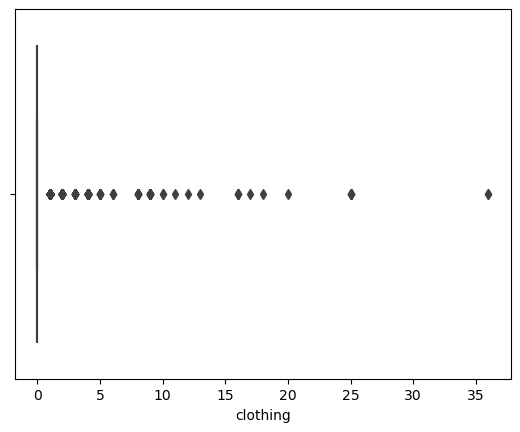

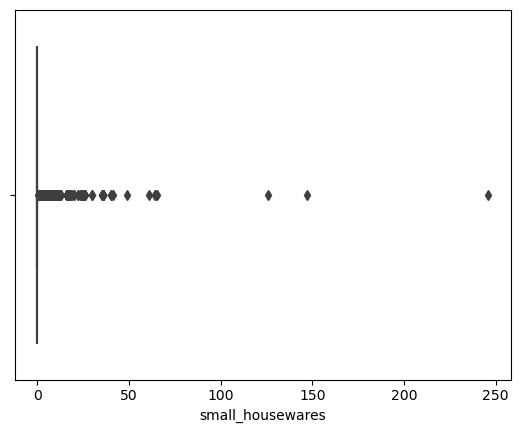

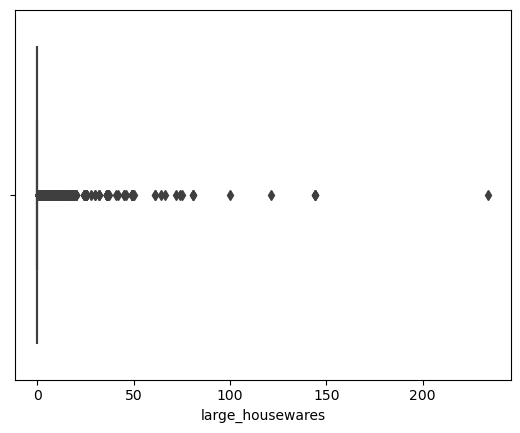

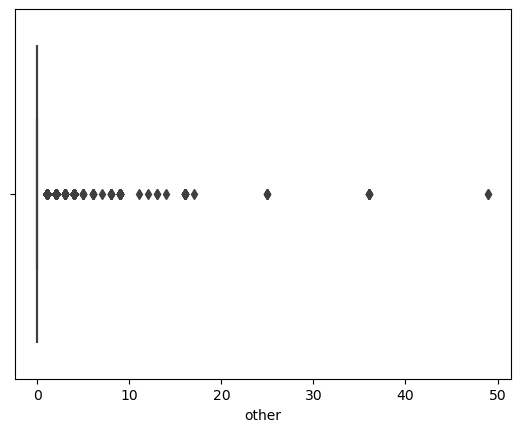

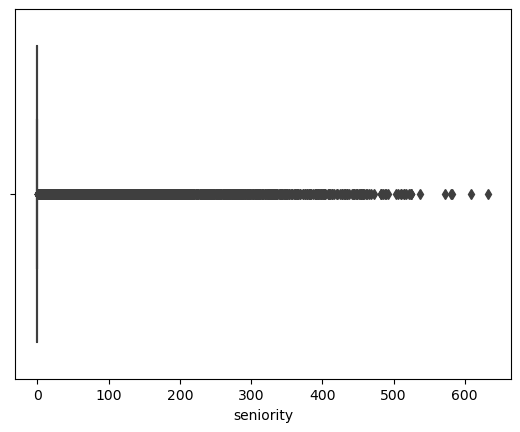

In [40]:
# Result after dropping the outliers

for col in df.select_dtypes(exclude = 'O'):
    sns.boxplot(data = df, x = col)
    plt.show()

# 3. EDA

Now that the dataset have been cleaned, an Exploratory Data Analysis (EDA) have been performed in order to better understand the dataset.

## 3.1 Product categories

First, the quantity of orders in the diffrent product categories is studied.

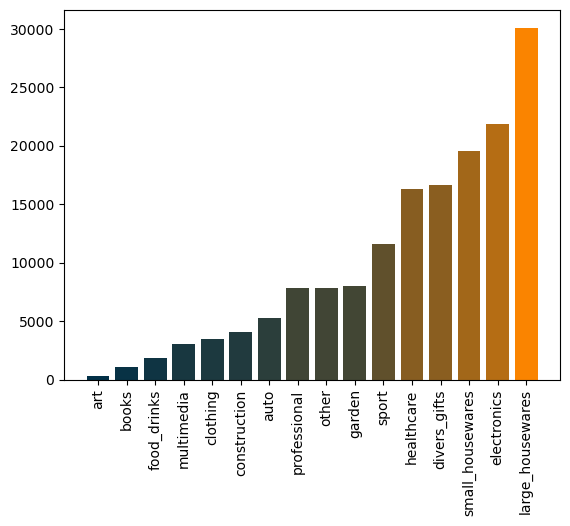

In [41]:
# Repartitions as histograms of the product categories are looked at
fig = plt.figure()

ax1 = fig.add_subplot()
ax1.bar(x = df[df_subcategories.index].sum(axis = 0).sort_values().index,
        height = df[df_subcategories.index].sum(axis = 0).sort_values(),
        color = color_bar(df[df_subcategories.index].sum(axis = 0).sort_values()))

ax1.tick_params(axis='x', labelrotation=90)


The distribution between different categories can vary greatly. We can see that most of the orders concerns :
- electronics
- small housewares
- divers/gifts
- healthcare


Then the repartision in mean value is displayed

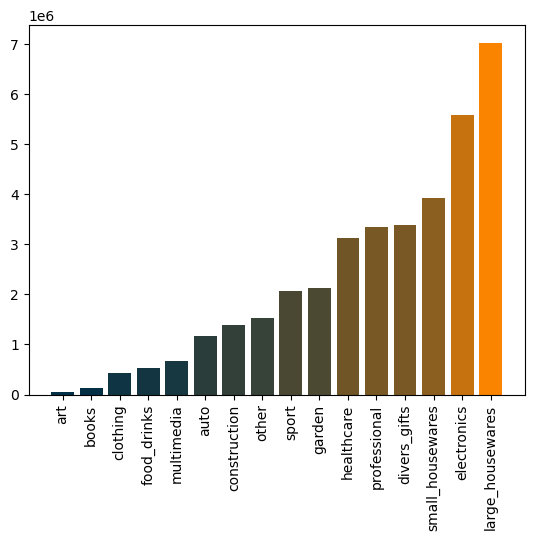

In [42]:
y = df[df_subcategories.index].T.dot(df['value_mean']).sort_values() # Calculate n article in a given cat * value_mean

fig = plt.figure()

ax1 = fig.add_subplot()
ax1.bar(x = y.index,
        height = y,
        color = color_bar(y))

ax1.tick_params(axis='x', labelrotation=90)

The ranking is more or less similar with few exceptions :
 - clothing and sport decrease

These changes could be imputed to the average cost of the given products. This hypothesis is verified :

In [43]:
# df_products and df_items are merged
df_product_price = df_products[['product_id', 'product_category_name']].merge(df_items[['product_id', 'price']],
                                on = 'product_id')

# category names are replaced with subcategories

for index, row in df_product_price.iterrows():
    for cat in df_subcategories.index:
        if row['product_category_name'] in df_subcategories.loc[cat, 'cat_list']:
            df_product_price.loc[index, 'product_category_name'] = cat

(0.0, 400.0)

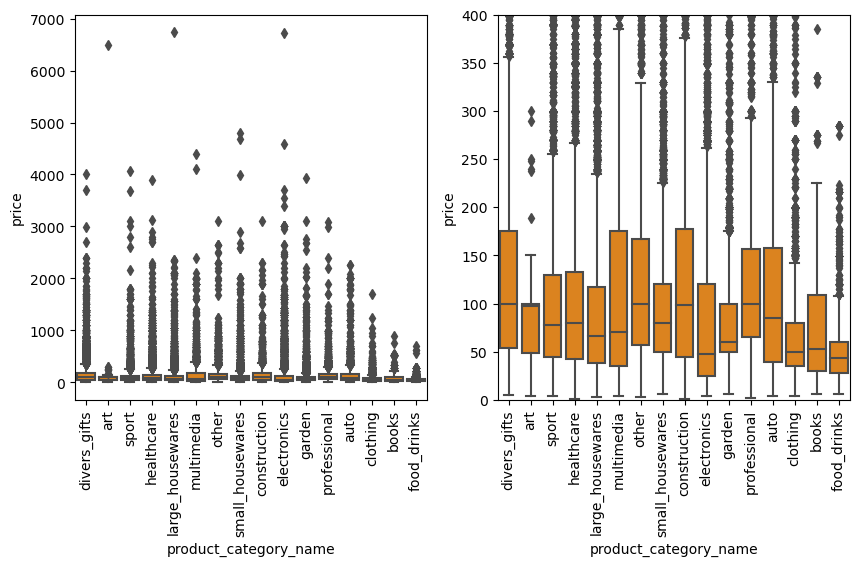

In [44]:
fig = plt.figure(figsize = (10,5))

ax1 = fig.add_subplot(1,2,1)
sns.boxplot(data = df_product_price,
            x = 'product_category_name',
            y = 'price',
            color = c_1)
ax1.tick_params(axis='x', labelrotation=90)

# create a zoom
ax2 = fig.add_subplot(1,2,2)
sns.boxplot(data = df_product_price,
            x = 'product_category_name',
            y = 'price',
            color = c_1)
ax2.tick_params(axis='x', labelrotation=90)
ax2.set_ylim(0,400)


## 3.2 Repartion by state

The habits of customer depending on their state is also observed.

First the mean and total frequency by state as well as the mean and total value by state is represented.

C:\Users\alfre\AppData\Local\Temp\ipykernel_12720\3641201648.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_state.loc[:,'customer_state'] = df_state['customer_state'].apply(lambda x : x[0] if type(x) == np.ndarray else x)


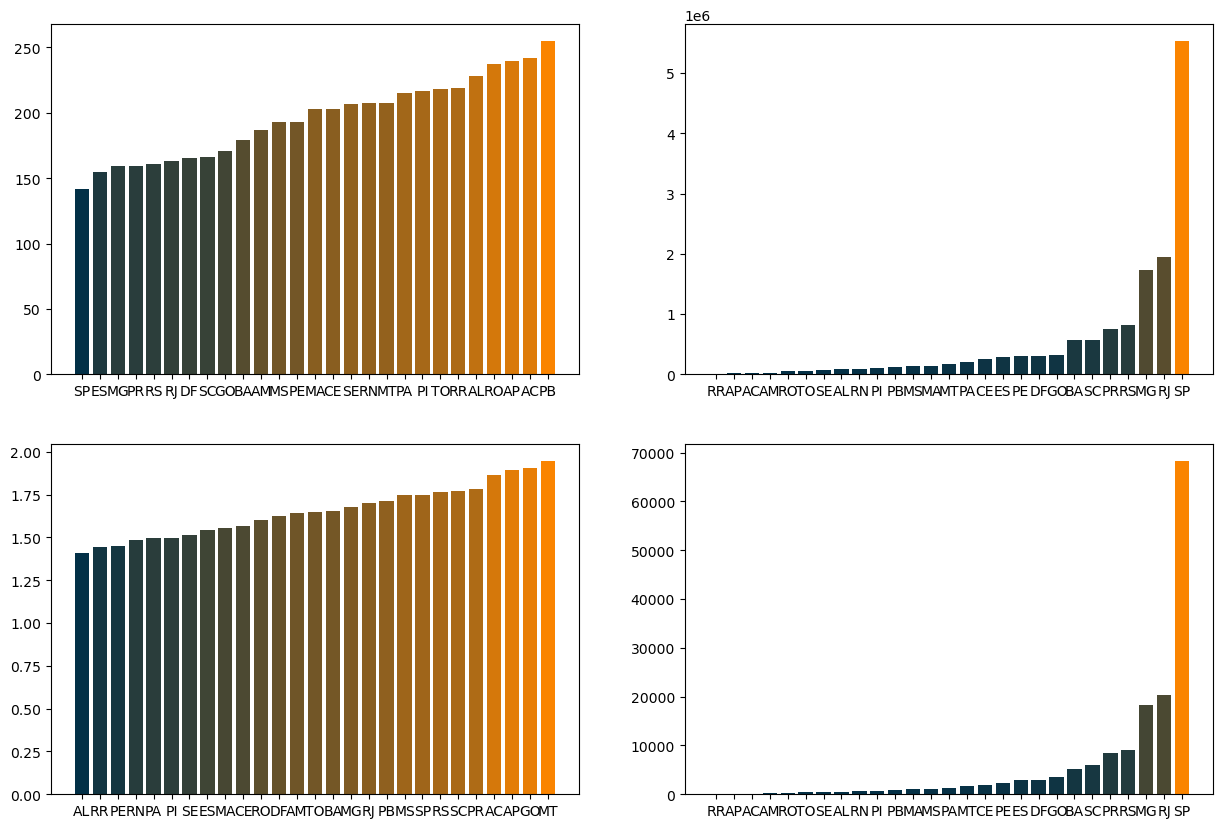

In [45]:
df_state = df[['customer_state', 'value_mean', 'frequency','main_category']]

# There are users with multiple state as 'mode' so the first one is taken
df_state.loc[:,'customer_state'] = df_state['customer_state'].apply(lambda x : x[0] if type(x) == np.ndarray else x)


# The index is reseted to use this field to count users from a given state
df_state = df_state.reset_index().groupby('customer_state').agg({'value_mean' : ['sum', 'mean'],
                                                                 'frequency' : ['sum', 'mean'],
                                                                 'customer_unique_id':'count',
                                                                 'main_category' : pd.Series.mode})

# There are sates with multiple main categories as 'mode' so the first one is taken
df_state.loc[:,('main_category', 'mode')] = df_state[('main_category', 'mode')].apply(lambda x : x[0] if type(x) == np.ndarray else x)

fig, axes = plt.subplots(2,2, figsize = (15,10))

ax_counter = 0 # Count at which ax attribute a given data
for col in ['value_mean', 'frequency']:
    
    axes[ax_counter, 0].bar(x = df_state[col]['mean'].sort_values().index,
                      height = df_state[col]['mean'].sort_values(),
                      color = color_bar (df_state[col]['mean'].sort_values()))
    
    axes[ax_counter, 1].bar(x = df_state[col]['sum'].sort_values().index,
                      height = df_state[col]['sum'].sort_values(),
                      color = color_bar (df_state[col]['sum'].sort_values()))
    ax_counter += 1

plt.show()

<font color='FB8500'>/!\ In order to avoid to eavy notebooks, maps have not been rendered but replaced with corresponding images.</font>

In [ ]:
# Code inspired from the article 'Interactive choropleth with Python and Folium (and some tips)'
# https://vverde.github.io/blob/interactivechoropleth.html

# Geo data are from click that hood project : https://github.com/codeforgermany/click_that_hood


def choropleth(data, col, alias):
# Select the convenient data and merge the GEOJSON file containing the poly info with the data
    geo_data = gpd.read_file('brazil_states.geojson')


    geo_data = geo_data.merge(data,
                   left_on = 'sigla',
                   right_on = 'customer_state')

    # Create the map
    m = folium.Map(location = [-11.314616, -49.462784],
                   zoom_start = 4)


    # Backgroup Choropleth map
    folium.Choropleth(
        geo_data=geo_data,
        name="choropleth",
        data=geo_data,
        columns=['sigla',col],
        key_on="properties.sigla",
        fill_color= 'YlGnBu',
        legend_name=alias,
    ).add_to(m)

    # Style of the overlay
    style_function = lambda x: {'fillColor': '#ffffff', 
                                'color':'#000000', 
                                'fillOpacity': 0.1, 
                                'weight': 0.1}
    # Style when hovering
    highlight_function = lambda x: {'fillColor': '#000000', 
                                    'color':'#000000', 
                                    'fillOpacity': 0.50, 
                                    'weight': 0.1}
    NIL = folium.features.GeoJson(
        geo_data,
        style_function=style_function, 
        control=False,
        highlight_function=highlight_function, 
        tooltip=folium.features.GeoJsonTooltip(
            fields=['name',col],
            aliases=['State: ',alias],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
        )
    )

    m.add_child(NIL)
    m.keep_in_front(NIL)
    folium.LayerControl().add_to(m)

    return m

choropleth(df_state['value_mean'],'sum', 'Total value')

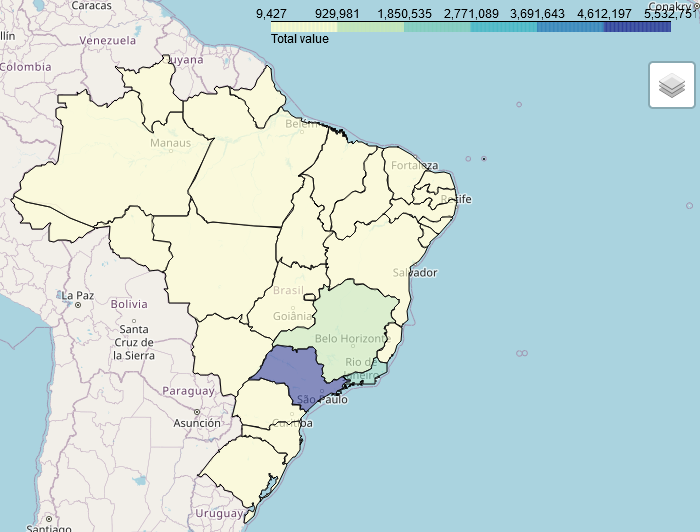

In [47]:
geo_data = gpd.read_file('brazil_states.geojson')


# geo_data = geo_data.merge(data,
#                    left_on = 'sigla',
#                    right_on = 'customer_state')

# geo_data.head()

In [ ]:
choropleth(df_state['value_mean'],'mean', 'Mean value')

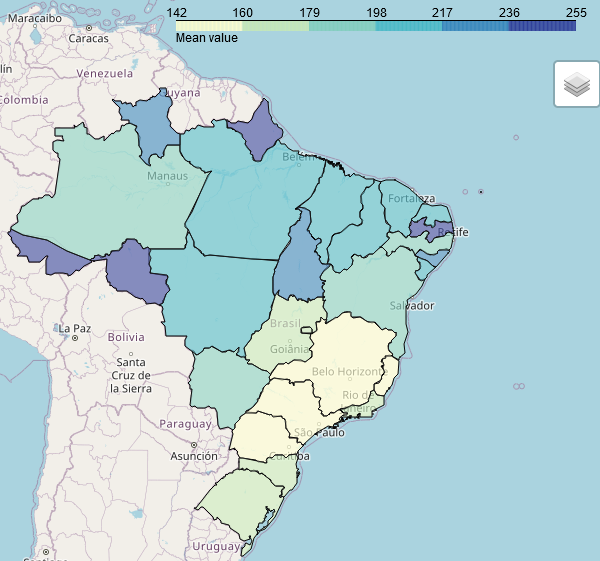

In [ ]:
choropleth(df_state['frequency'],'mean', 'Mean frequency')

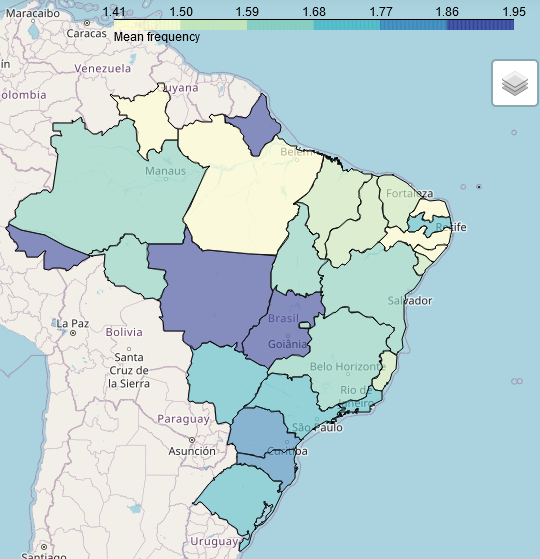

In [ ]:
choropleth(df_state['frequency'],'sum', 'Total frequency')

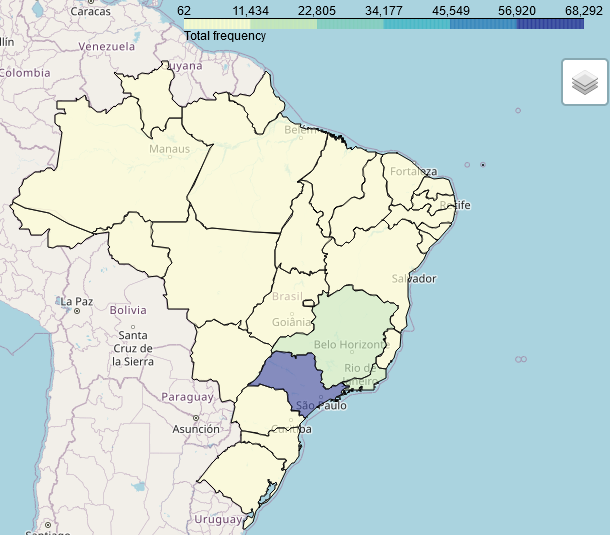

It is interesting to note that the regions with cutomers that invest the higher mean value et by with the higher mean frequency are not the region with the cumulated higher frequency and invested value.

The cumulated invested value and frequency can be linked to the number of user and population in the given states.

C:\Users\alfre\AppData\Local\Temp\ipykernel_12720\2072217021.py:5: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  brazil_pop = brazil_pop.merge(df_state,


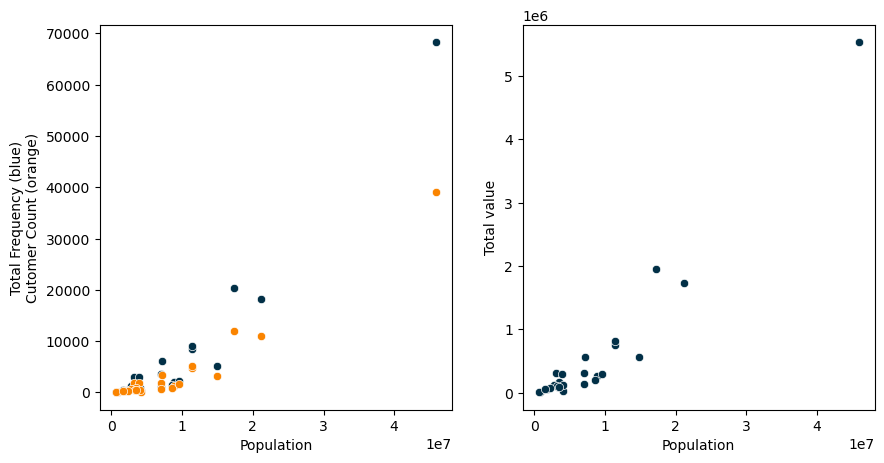

In [51]:
# Brazil population by state is loaded from https://en.wikipedia.org/wiki/Federative_units_of_Brazil
brazil_pop = pd.read_csv('brazil_population.csv', sep = '\t')

# The data are merged
brazil_pop = brazil_pop.merge(df_state,
                 left_on = 'Code',
                 right_on = 'customer_state')

fig = plt.figure(figsize = (10,5))

ax1 = fig.add_subplot(1,2,1)
sns.scatterplot(x = brazil_pop['Population'],
                y = brazil_pop[('frequency', 'sum')],
                ax = ax1,
                color = c_0)

sns.scatterplot(x = brazil_pop['Population'],
                y = brazil_pop[('customer_unique_id', 'count')],
                ax = ax1,
                color = c_1)
ax1.set_ylabel('Total Frequency (blue)\nCutomer Count (orange)')

ax2 = fig.add_subplot(1,2,2)
sns.scatterplot(x = brazil_pop['Population'],
                y = brazil_pop[('value_mean', 'sum')],
                ax = ax2,
                color = c_0)
ax2.set_ylabel('Total value')

plt.show()

Then, the categroy of products that is the most represed in a given state is represeted

<AxesSubplot:xlabel='Population', ylabel="('frequency', 'sum')">

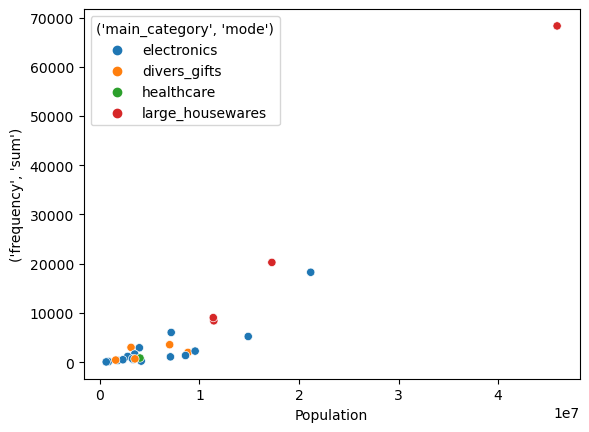

In [52]:
sns.scatterplot(x = brazil_pop['Population'],
                y = brazil_pop[('frequency', 'sum')],
                hue = brazil_pop[('main_category', 'mode')])

It seems that in the most populated states, large housewares are the more popular articles. They are followed by electronics and divers_gifts in less populated area.

C:\Users\alfre\AppData\Local\Temp\ipykernel_12720\222578561.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_state.loc[:,'customer_state'] = df_state['customer_state'].apply(lambda x : x[0] if type(x) == np.ndarray else x)


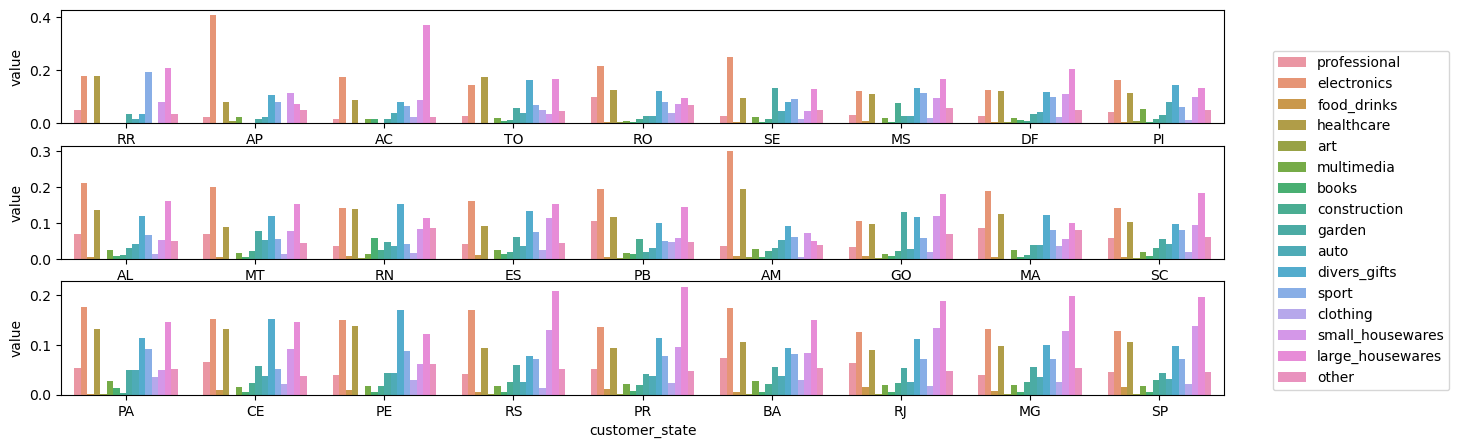

In [53]:
df_state = df[['customer_state']+list(df_subcategories.index)]

# There are users with multiple state as 'mode' so the first one is taken
df_state.loc[:,'customer_state'] = df_state['customer_state'].apply(lambda x : x[0] if type(x) == np.ndarray else x)


# the data are grouped by state and summed tu get the number of item by states
df_state = df_state.groupby('customer_state').sum()

# The dataframe is ordered depending on the population of a given state
df_state = df_state.loc[brazil_pop.sort_values(by = 'Population')['Code']]


# The data are normalized to have percentage
for index, row in df_state.iterrows():
    df_state.loc[index] = row/(row.sum())

# for readability the graph cut in parts
fig, axes = plt.subplots(3, 1, figsize = (15, 5))

for i in range(3):
    df_state_cut = df_state.iloc[i*9 :(i+1)*9]
    sns.barplot(x = (df_state_cut.melt(ignore_index=False)['value']).index, # data is culumn are set to rows thanks to melt
                y = df_state_cut.melt(ignore_index=False)['value'],
                hue = df_state_cut.melt(ignore_index=False)['variable'],
                ax = axes[i])
    if i == 0:
        axes[0].legend(loc = 'upper right', bbox_to_anchor = (1.2, .7))
    else:
        axes[i].get_legend().remove()

When ignoring the major category, all cities have a resembling profile in therms of frequency in each categories.

It is interesting to note that eventhough AC have low relative population it present a similar profile to more populated states as SP and RJ. Thus, other factor must play a role.

## 3.3 Payment method

Another parameter that is looked at is the payment method:

In [54]:
# As some payment types have multiple mode the first one is arbitrary choosen
df.loc[:,'payment_type'] = df['payment_type'].apply(lambda x : x[0] if type(x) == np.ndarray else x)

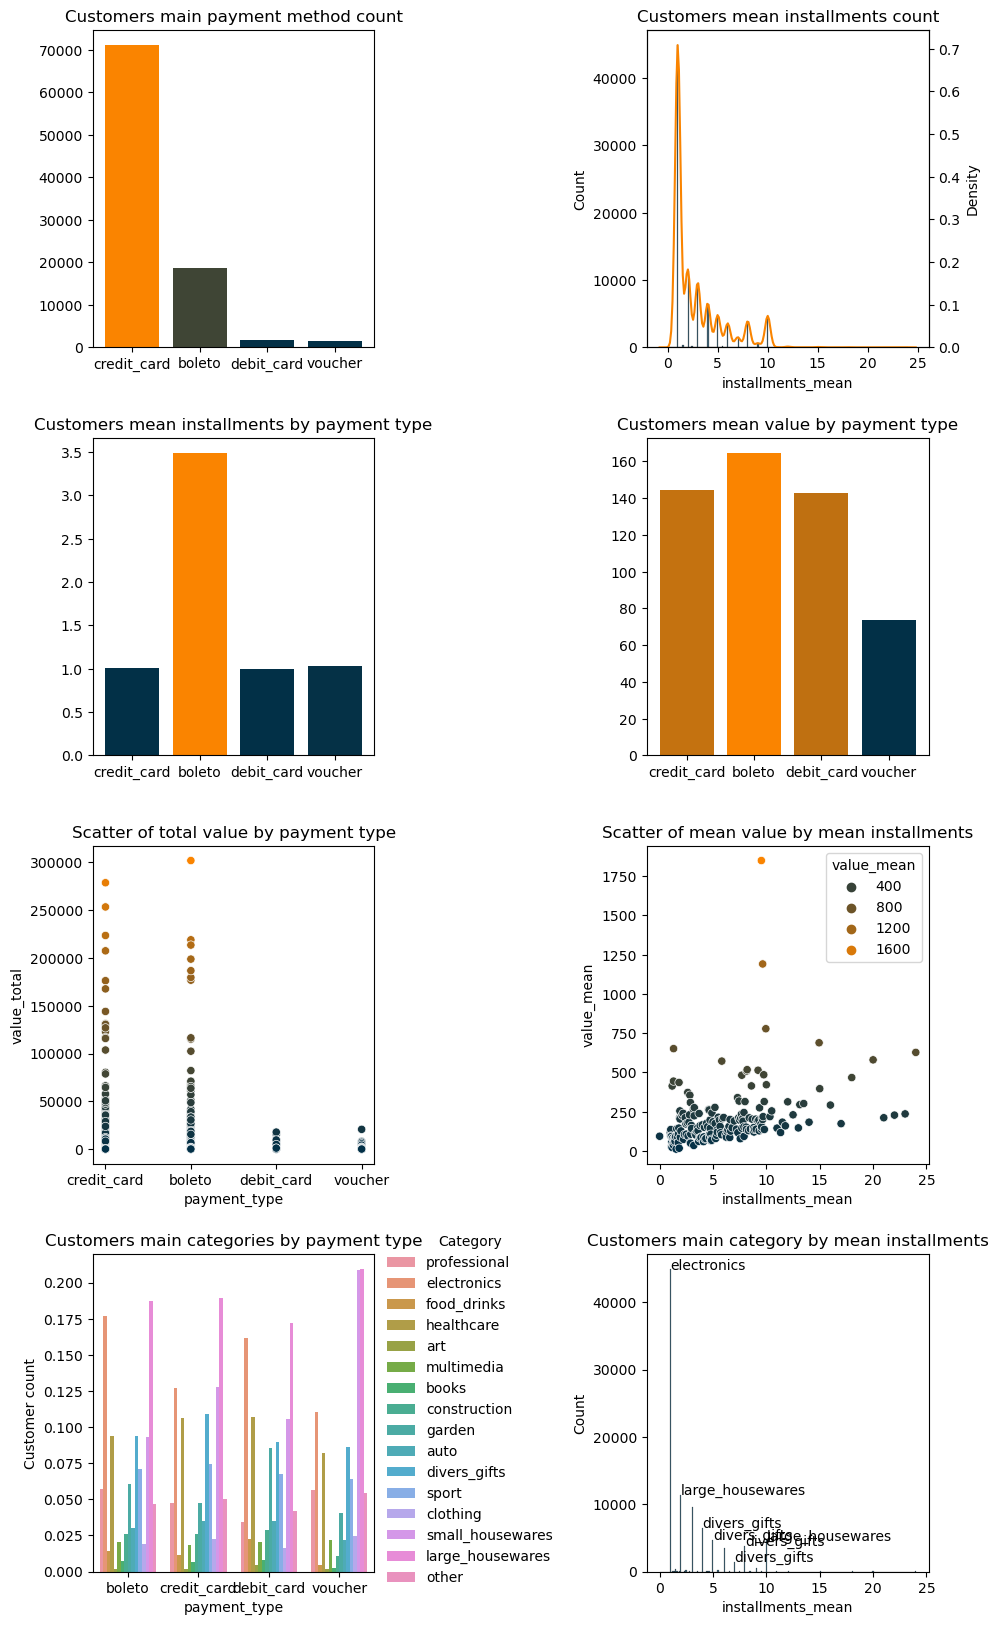

In [55]:
fig = plt.figure(figsize = (10, 20))

# Proportion by payment type
ax1 = fig.add_subplot(5,2,1)
ax1.bar(x = df['payment_type'].unique(),
        height = df['payment_type'].value_counts(),
        color = color_bar(df['payment_type'].value_counts()))
ax1.set_title('Customers main payment method count')

# Proportion by installments
ax2 = fig.add_subplot(5,2,2)
sns.histplot(x = df['installments_mean'], ax = ax2, color = c_0)
ax3 = ax2.twinx()
sns.kdeplot(x = df['installments_mean'], ax = ax3, color = c_1)

ax3.set_title('Customers mean installments count')

# Proportion in installments by payment type
ax4 = fig.add_subplot(5,2,3)
ax4.bar(x = df['payment_type'].unique(),
        height = df[['payment_type','installments_mean']].groupby('payment_type').mean().values.reshape(-1,),
        color = color_bar(df[['payment_type','installments_mean']].groupby('payment_type').mean().values.reshape(-1,)))
ax4.set_title('Customers mean installments by payment type')

# Value mean by payment type
ax5 = fig.add_subplot(5,2,4)
ax5.bar(x = df['payment_type'].unique(),
        height = df[['payment_type','value_mean']].groupby('payment_type').mean().values.reshape(-1,),
        color = color_bar(df[['payment_type','value_mean']].groupby('payment_type').mean().values.reshape(-1,)))
ax5.set_title('Customers mean value by payment type')

# scatter of Value total by payment type
ax6 = fig.add_subplot(5,2,5)

sns.scatterplot(data = df[['payment_type','value_total']],
                x = 'payment_type',
                y = 'value_total',
                hue = 'value_total',
                ax = ax6,
                palette = custom_cmp1)
ax6.get_legend().remove()
ax6.set_title('Scatter of total value by payment type')

# Paying value by Installemnts_mean
ax7 = fig.add_subplot(5,2,6)

sns.scatterplot(data = df[['installments_mean','value_mean']].groupby('installments_mean').mean(),
                x = df[['installments_mean','value_mean']].groupby('installments_mean').mean().index,
                y = 'value_mean',
                hue = 'value_mean',
                palette = custom_cmp1,
                ax = ax7)
ax7.set_title('Scatter of mean value by mean installments')

# Main category by payment type
ax8 = fig.add_subplot(5,2,7)

df_payment_cat = df[['payment_type']+list(df_subcategories.index)].groupby('payment_type').sum()
## Normalise the data between 0 and :
for index, row in df_payment_cat.iterrows():
    df_payment_cat.loc[index,:] = row/row.sum()

sns.barplot(data = df_payment_cat.melt(ignore_index = False).reset_index(),
            x = 'payment_type',
            y = 'value',
            hue = 'variable',
            ax = ax8)
ax8.legend(loc = 'upper left', bbox_to_anchor = (1, 1.1), frameon = False, title = 'Category')

ax8.set_ylabel('Customer count')
ax8.set_title('Customers main categories by payment type') 

# Main category by payment type
ax9 = fig.add_subplot(5,2,8)

sns.histplot(x = df['installments_mean'], ax = ax9, color = c_0, bins = 200)

density, edges = np.histogram(df['installments_mean'], bins = 200)
for i in range(1, 11):
    for index, value in np.ndenumerate(edges):
        if i>edges[index[0]] and i<edges[index[0]+1]:
            ax9.annotate(df[df['installments_mean'] == i]['main_category'].mode().iloc[0],
                        (i, density[index]))
            break


ax9.set_title('Customers main category by mean installments')

plt.tight_layout()

Multiple observation can be drawn from the previous figures :
- The main payment method (in count) is credit cards
- The majority of cutomers use only one installment
- The proportion of a number of installment decrease when the number of of installment increase until a low rebound at 10
- Multiple installments seems favourised when paying with "boleto".
- Other payment means seems to be used with single installments
- Voucher seems to be used for the payments with the lower value in average
- In total, voucher and debit cards are employed for the lower amounts
- In a general manner, high number of installments are used for high value payment (with a visible pic at 10, maybe favourised by the website)
- The profile in therm of categories appears not diffrent form a payment mean to another
- Articles from the category *electronics* are usualy purshased with single installment
- Articles from the category *large_houseware* and *divers_gifts* are often purshased with multiple installment

## 3.4 Review score

Finaly the habits of customers in therms of grading and comments are looked at.

Theses observation are linked other parameters as mean value or delivery time.

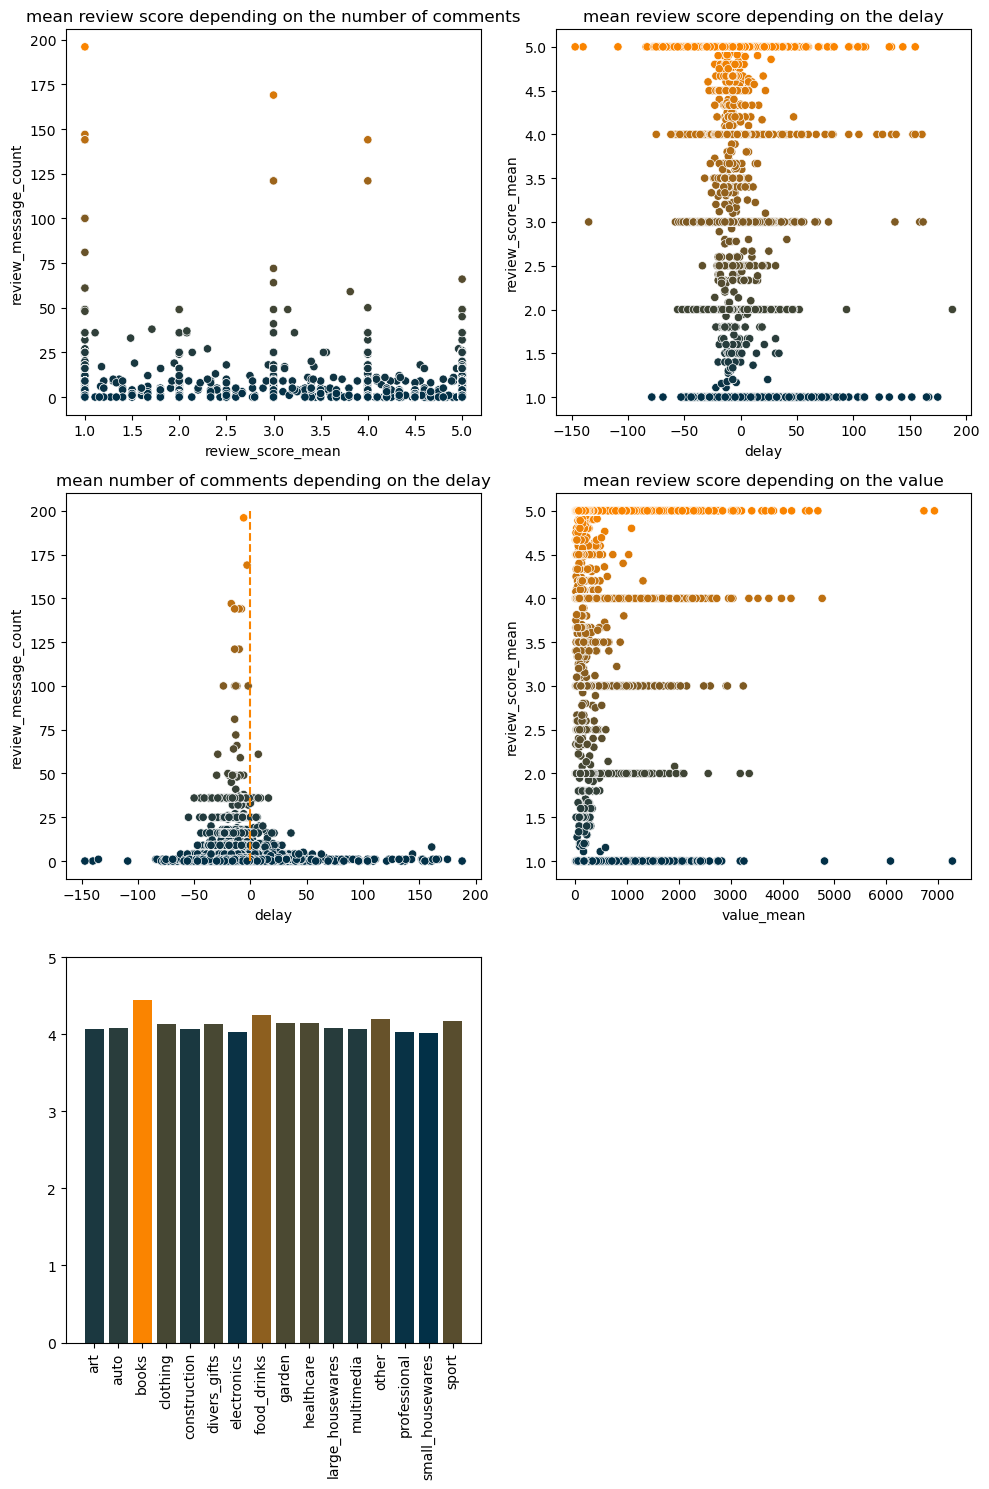

In [56]:
fig = plt.figure(figsize = (10,15))

# number of messages vs review score
ax1 = fig.add_subplot(3,2,1)
sns.scatterplot(data = df,
                x = 'review_score_mean',
                y = 'review_message_count',
                hue = 'review_message_count',
                palette = custom_cmp1,
                ax = ax1)
ax1.get_legend().remove()
ax1.set_title('mean review score depending on the number of comments')

# review score vs delay
ax2 = fig.add_subplot(3,2,2)
sns.scatterplot(data = df,
                x = 'delay',
                y = 'review_score_mean',
                hue = 'review_score_mean',
                palette = custom_cmp1,
                ax = ax2)
ax2.get_legend().remove()
ax2.set_title('mean review score depending on the delay')

# number of messages vs delay
ax3 = fig.add_subplot(3,2,3)
sns.scatterplot(data = df,
                x = 'delay',
                y = 'review_message_count',
                hue = 'review_message_count',
                palette = custom_cmp1,
                ax = ax3)
ax3.plot([0,0], [0, 200], color = c_1, linestyle = '--')
ax3.get_legend().remove()
ax3.set_title('mean number of comments depending on the delay')

# mean review score vs value
ax3 = fig.add_subplot(3,2,4)
sns.scatterplot(data = df,
                x = 'value_mean',
                y = 'review_score_mean',
                hue = 'review_score_mean',
                palette = custom_cmp1,
                ax = ax3)
ax3.get_legend().remove()
ax3.set_title('mean review score depending on the value')

# mean review score by main category
ax4 = fig.add_subplot(3,2,5)

ax4.bar(x = df[['review_score_mean', 'main_category']].groupby('main_category').mean().reset_index()['main_category'],
        height = df[['review_score_mean', 'main_category']].groupby('main_category').mean().reset_index()['review_score_mean'],
        color = color_bar(df[['review_score_mean', 'main_category']].groupby('main_category').mean().reset_index()['review_score_mean']))
ax4.tick_params(axis='x', labelrotation=90)
ax4.set_ylim(0,5)


plt.tight_layout()

In [ ]:
# Here the previous code and fuction are reused this time to display review score
# depending on a customer state

# mean review score by state
df_state = df[['customer_state','review_score_mean']]

# There are users with multiple state as 'mode' so the first one is taken
df_state.loc[:,'customer_state'] = df_state['customer_state'].apply(lambda x : x[0] if type(x) == np.ndarray else x)

df_state = df_state.reset_index().groupby('customer_state').agg({'review_score_mean' : ['sum', 'mean']}) # sum and mean are not necesary here but are inherited from the previous visualizations
choropleth(df_state['review_score_mean'],'mean', 'Mean review score')

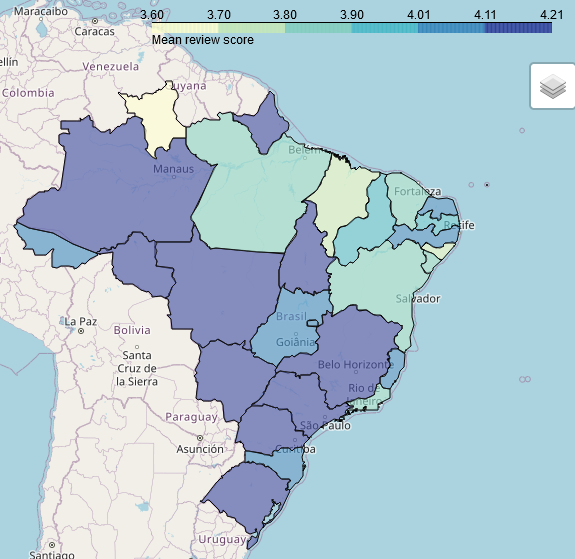

In [ ]:
# A similar map is displayed for the mean distance of orders

# mean review score by state
df_state = df[['customer_state','distance']]

# There are users with multiple state as 'mode' so the first one is taken
df_state.loc[:,'customer_state'] = df_state['customer_state'].apply(lambda x : x[0] if type(x) == np.ndarray else x)

df_state = df_state.reset_index().groupby('customer_state').agg({'distance' : ['sum', 'mean']}) # sum and mean are not necesary here but are inherited from the previous visualizations
choropleth(df_state['distance'],'mean', 'Mean Distance')

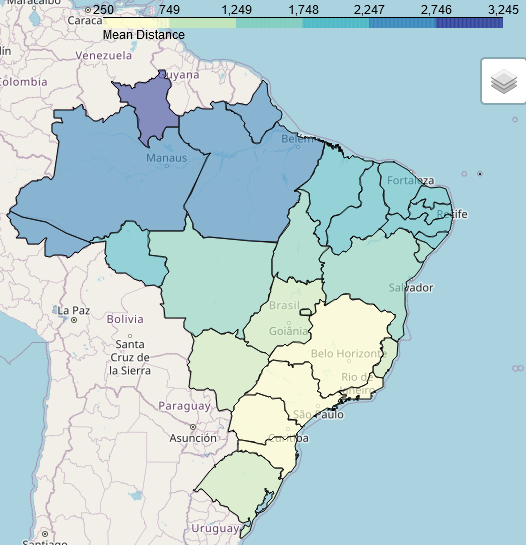

In [ ]:
# Finaly a similar map is displayed for the mean delay of orders

# mean review score by state
df_state = df[['customer_state','delay']]

# There are users with multiple state as 'mode' so the first one is taken
df_state.loc[:,'customer_state'] = df_state['customer_state'].apply(lambda x : x[0] if type(x) == np.ndarray else x)

df_state = df_state.reset_index().groupby('customer_state').agg({'delay' : ['max', 'mean']}) # sum and mean are not necesary here but are inherited from the previous visualizations
choropleth(df_state['delay'],'mean', 'Mean Delay')

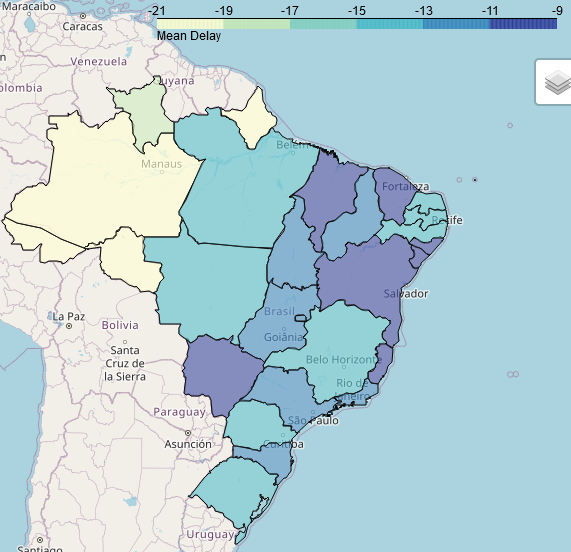

## 3.5 RFM values

As suggested in the project introduction, the features of the RFM system are evaluated for creating clusters. The values and especially their spreading in space have been studied in detail. Then a principal component analysis (PCA) has been performed in order to again better understand the link between the RFM features.

In [60]:
df_rfm = df[['recency', 'frequency', 'value_total']]

<font color='FB8500'>/!\ In order to avoid to eavy notebooks, 3D plots have not been rendered but corresponding images are displayed.</font>

In [ ]:
# First the data are represented in the three dimensions
fig = px.scatter_3d(df_rfm, x='recency', y='value_total', z='frequency', color = 'frequency', color_continuous_scale = [mpl.colors.to_hex(c_0), mpl.colors.to_hex(c_4)])
fig.show()

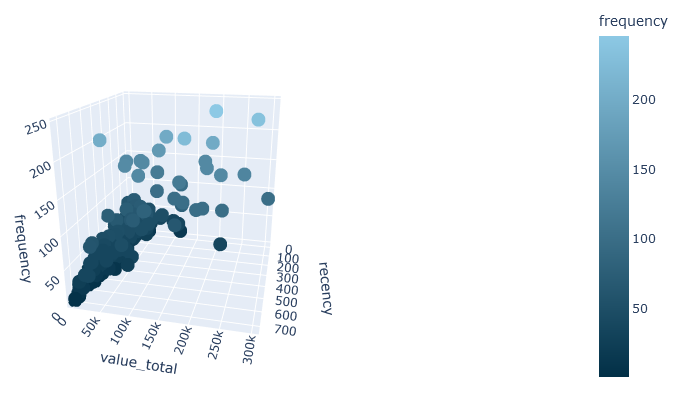

In [ ]:
# Value might be better represented on a log scale
fig = px.scatter_3d(df_rfm,
                    x='recency',
                    y='value_total',
                    z='frequency',
                    color = 'frequency',
                    color_continuous_scale = [mpl.colors.to_hex(c_0), mpl.colors.to_hex(c_4)], # Add custom color
                    log_x = False,
                    log_y = True,
                    log_z = True,
                    )
fig.show()

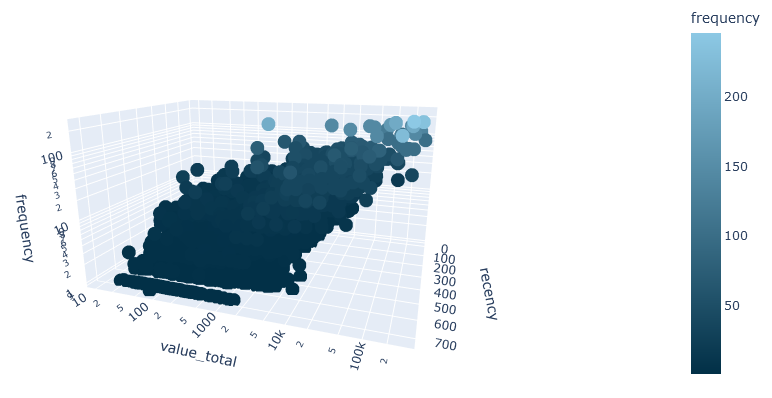

- No clear clusters appears
- there is a gap in recency between 650 and 750 days : maybe because of the start of the activity

In [63]:
# PCA is performed to better understand the link features - samples
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

x_sc = StandardScaler().fit_transform(df_rfm) # Data are first scaled and standardised

pca = PCA(n_components = 3)
pca.fit(x_sc)

PCA(n_components=3)

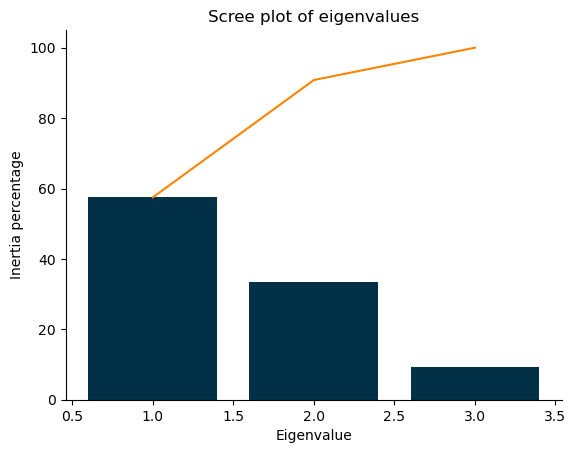

In [64]:
# The scree plot of eigenvalues is diplayed
from pca_graph import scree_plot

scree_plot(pca)

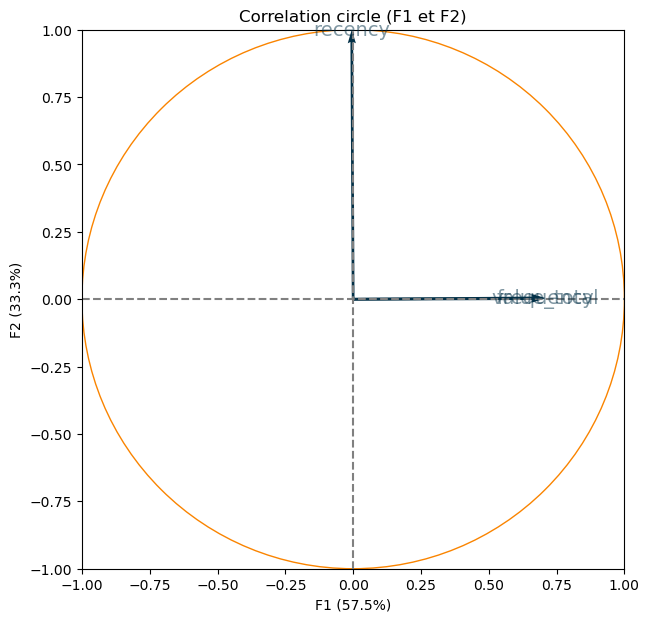

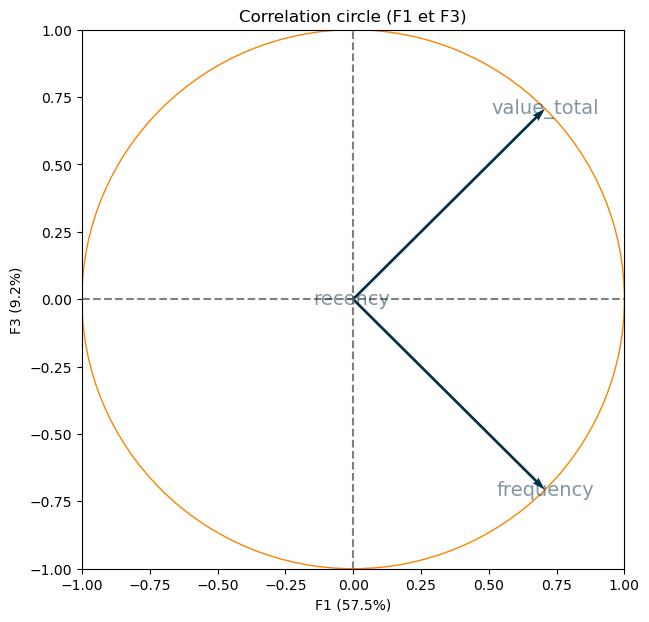

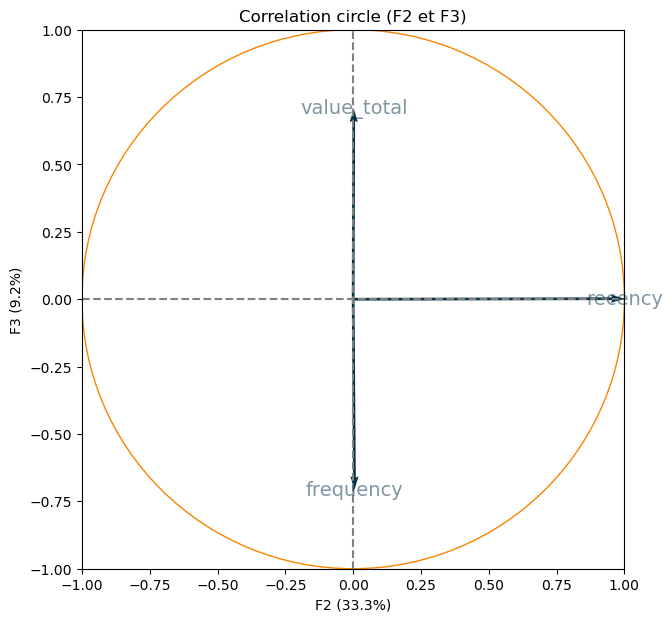

In [65]:
# The correlation circle is diplayed
from pca_graph import correlation_circle
# The code has been adapted from the file provided by openclassroom course :
# https://openclassrooms.com/fr/courses/4525281-realisez-une-analyse-exploratoire-de-donnees

correlation_circle(pca = pca, n_comp = 3, labels = df_rfm.columns)

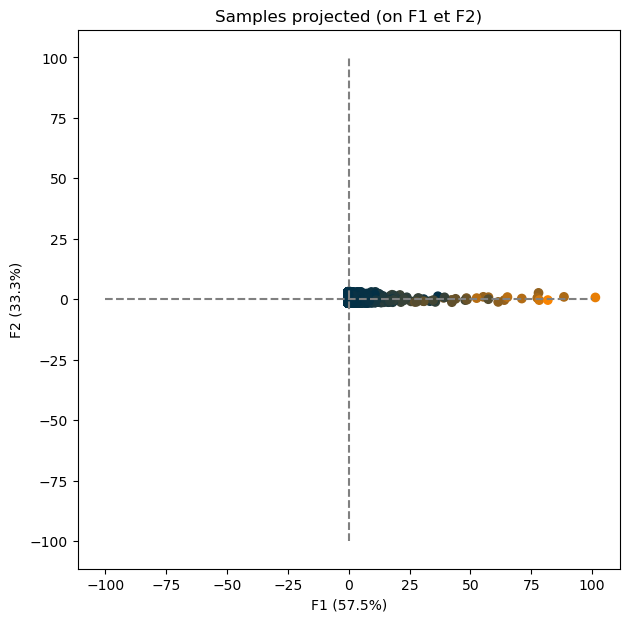

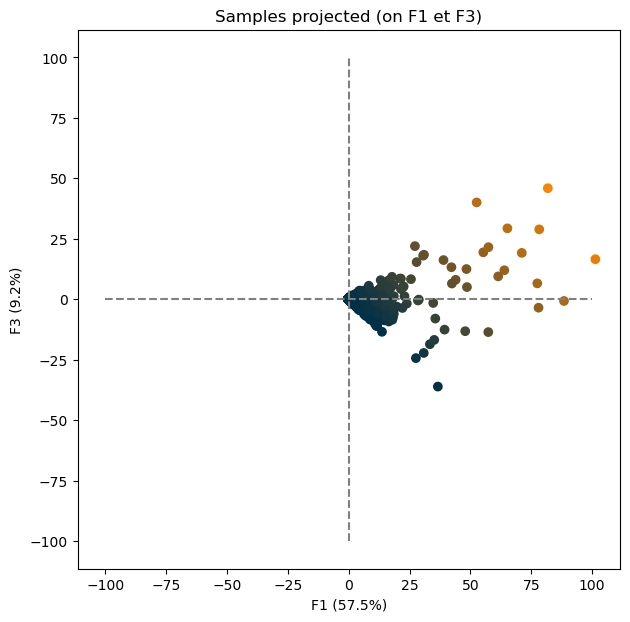

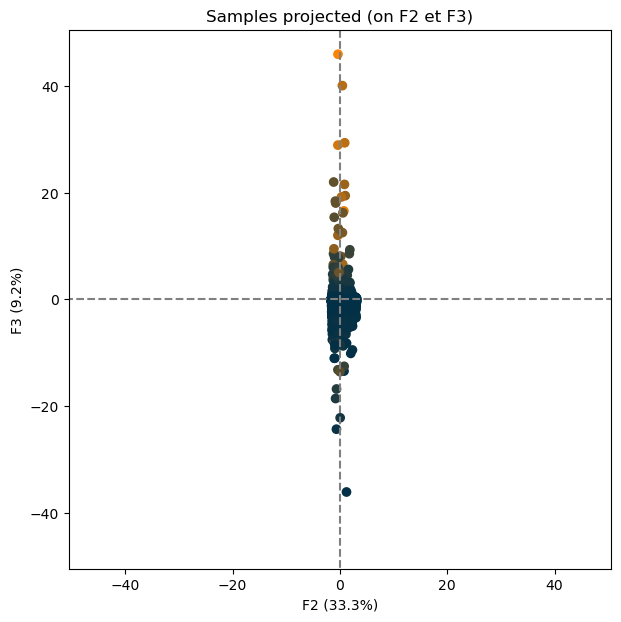

In [66]:
# The samples are then projected on the plane
from pca_graph import display_factorial_planes

display_factorial_planes(x_sc, pca, 3, labels=None, alpha=1, illustrative_var=df_rfm['value_total'], cmap = custom_cmp1)

In [67]:
# The data are exported in a csv file for model evaluation

df_rfm.to_csv('df_rfm.csv', index = False)

The 2 first component explains most of the inertia

F1 : Wheter the client did a lot of purchases (*value_total* + *frequency*)
F2 : Wheter the client bought recently (*recency*)
F3 : Wheter the client bought expensive items (*frequency* vs *value_total*)

**Conclusion :** the value from the RFM and especialy the *value_total* and *frequency* could be employed to create clusters.

## 3.2 Adding all numerical features

In order to understand if adding features to the RFM features could help having a better classification, a PCA in ran on the whole dataset. This study allows to understand better how the features are linked together.

In a first approach only numerical data are considered

In [68]:

df_num = df.select_dtypes(include= ['int64', 'float64'])

# Converting features to log for having a better distribution

x_sc = StandardScaler().fit_transform(df_num)

pca = PCA(n_components = df_num.shape[1])
pca.fit(x_sc)

PCA(n_components=31)

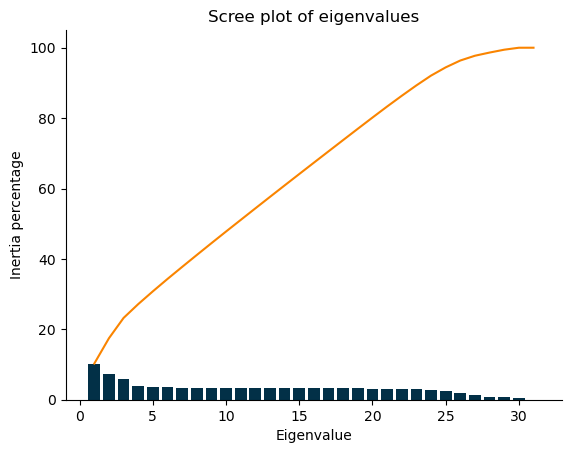

In [69]:
scree_plot(pca)

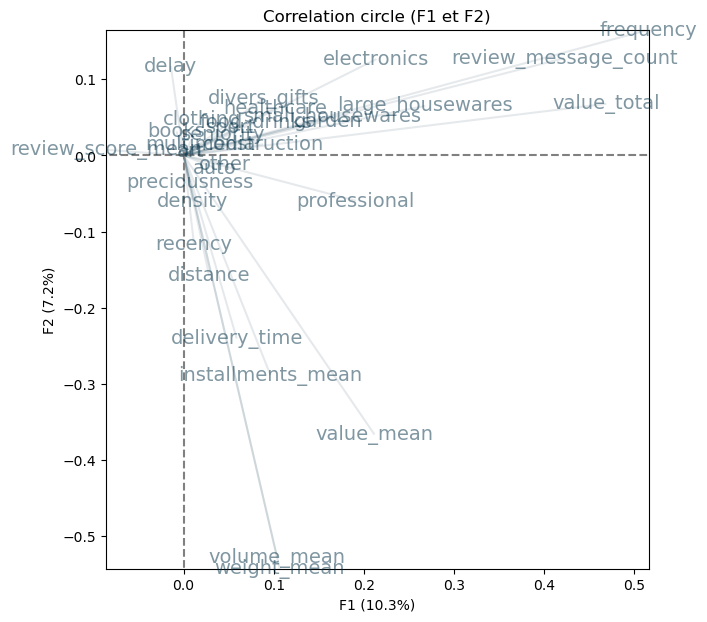

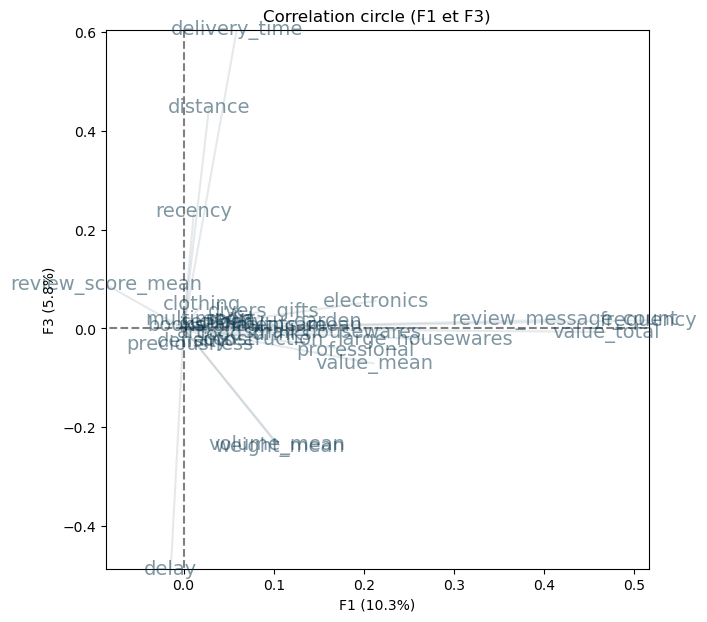

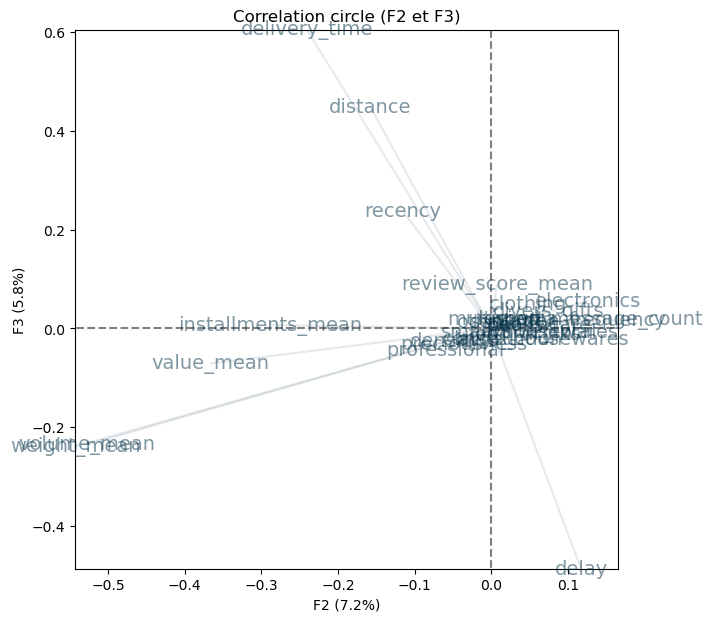

In [70]:
correlation_circle(pca = pca, n_comp = 3, labels = df_num.columns)

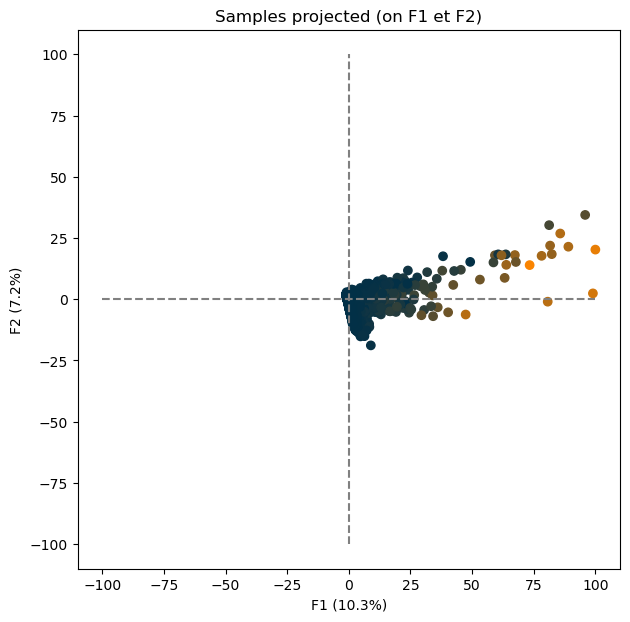

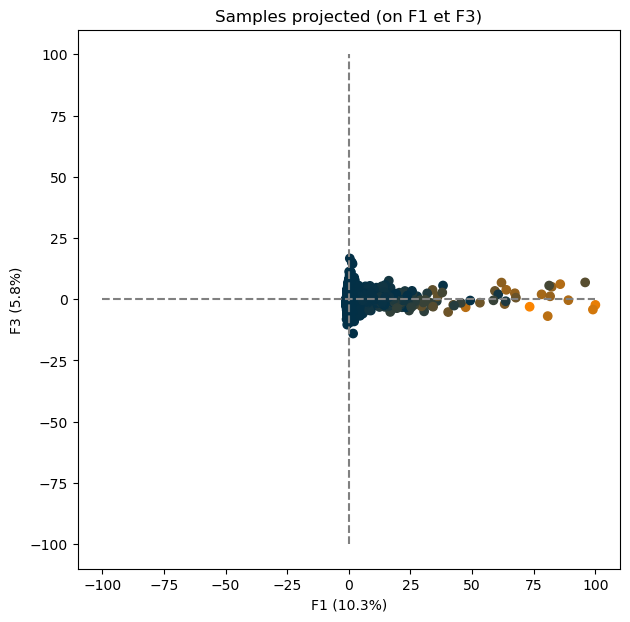

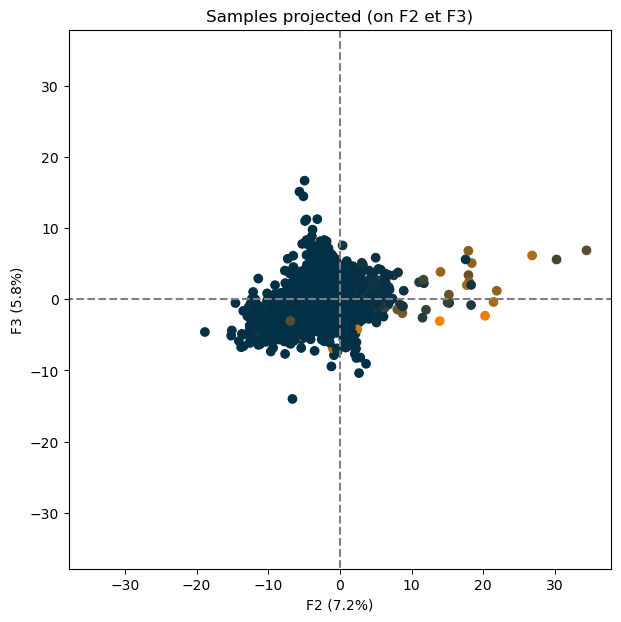

In [71]:
display_factorial_planes(x_sc, pca, 3, labels=None, alpha=1, illustrative_var=df_rfm['value_total'], cmap = custom_cmp1)

In [72]:
# The data are exported in a csv file for model evaluation

df_num.to_csv('df_num.csv', index = False)

## 3.2 Ordinal Encoding of categorical data

This time numerical categories are removed to avoid having a sparse dataset.

Insteed, categorical features are encoded with ordinal encoding.

In [73]:
df_enc = df.drop(df_subcategories.index, axis = 1) # droping encoded categories
df_enc = df_enc.drop(['customer_zip', 'seller_zip'], axis = 1)

In [74]:
# There are users with multiple state as 'mode' so the first one is taken
df_enc.loc[:,'customer_state'] = df_enc['customer_state'].apply(lambda x : x[0] if type(x) == np.ndarray else x)

df_enc['customer_state'] = LabelEncoder().fit_transform(df_enc['customer_state'])

df_enc['payment_type'] = LabelEncoder().fit_transform(df_enc['payment_type'].values)

df_enc['main_category'] = LabelEncoder().fit_transform(df_enc['main_category'].values)

In [75]:
# The data are exported for modelisation

df_enc.to_csv('df_enc.csv')

## 3.2 One Hot Encoding of categorical data with value

In order to underline purshase of expensive articles in a given category, the ecoded value for a given category could be the average amount insted of the number of orders.

In [76]:
# Starting from df of customers with order IDs
df_cat_price = df_customers[['customer_id', 'customer_unique_id']]

# Merging with df_orders and items to get category and price
df_cat_price = pd.merge(df_cat_price, pd.merge(df_orders[['customer_id', 'order_id']], # Merge df_raw with df_products through df_orders and d_items
                                               pd.merge(df_items[['order_id', 'product_id','price']],
                                                        df_products[['product_id', 'product_category_name']],
                                                        on = 'product_id'),
                           
                                               on = 'order_id')[['customer_id','price', 'product_category_name']],
                        on = 'customer_id')
# Converting categories
for cat in df_subcategories.index:
    df_cat_price[cat] = np.zeros((df_cat_price.shape[0],))

# The price is added for each product wich belong to a given subcategory

for index, row in df_cat_price.iterrows():
    for cat in df_subcategories.index:
        if row['product_category_name'] in df_subcategories.loc[cat, 'cat_list']:
            df_cat_price.loc[index, cat] = df_cat_price.loc[index, 'price']

# The data are grouped by customers
df_cat_price = df_cat_price.groupby('customer_unique_id').agg({cat : 'mean' for cat in df_subcategories.index})

In [77]:
# Re_index the data with data from the original dataframe
df_cat_price = df_cat_price.loc[df.index]

In [78]:
# Joining the dataframes
df_cat_price = df_cat_price.join(df, lsuffix = '', rsuffix = '_frequency')


In [79]:
# Removing previous frequency encoding and keeping numerical features
df_cat_price = df_cat_price.drop([f'{cat}_frequency' for cat in df_subcategories.index], axis = 1)
df_cat_price = df_cat_price.select_dtypes(exclude = 'O')

df_cat_price.head()

professional  electronics  food_drinks  \
customer_unique_id                                                         
0000366f3b9a7992bf8c76cfdf3221e2           0.0         0.00          0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f           0.0         0.00          0.0   
0000f46a3911fa3c0805444483337064          69.0         0.00          0.0   
0000f6ccb0745a6a4b88665a16c9f078           0.0        25.99          0.0   
0004aac84e0df4da2b147fca70cf8255           0.0       180.00          0.0   

                                  healthcare  art  multimedia  books  \
customer_unique_id                                                     
0000366f3b9a7992bf8c76cfdf3221e2         0.0  0.0         0.0    0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f        18.9  0.0         0.0    0.0   
0000f46a3911fa3c0805444483337064         0.0  0.0         0.0    0.0   
0000f6ccb0745a6a4b88665a16c9f078         0.0  0.0         0.0    0.0   
0004aac84e0df4da2b147fca70cf8255         0.0  0.0         0.0    0.0   

                                  construction  garden  auto  ...  \
customer_unique_id                                            ...   
0000366f3b9a7992bf8c76cfdf3221e2           0.0     0.0   0.0  ...   
0000b849f77a49e4a4ce2b2a4ca5be3f           0.0     0.0   0.0  ...   
0000f46a3911fa3c0805444483337064           0.0     0.0   0.0  ...   
0000f6ccb0745a6a4b88665a16c9f078           0.0     0.0   0.0  ...   
0004aac84e0df4da2b147fca70cf8255           0.0     0.0   0.0  ...   

                                  installments_mean  recency  delivery_time  \
customer_unique_id                                                            
0000366f3b9a7992bf8c76cfdf3221e2                8.0      115             10   
0000b849f77a49e4a4ce2b2a4ca5be3f                1.0      118              7   
0000f46a3911fa3c0805444483337064                8.0      541             27   
0000f6ccb0745a6a4b88665a16c9f078                4.0      325             31   
0004aac84e0df4da2b147fca70cf8255                6.0      292             20   

                                  delay  volume_mean    density  preciousness  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2   -5.0       7616.0   0.196954     10.570825   
0000b849f77a49e4a4ce2b2a4ca5be3f   -5.0       5148.0   0.072844     13.791835   
0000f46a3911fa3c0805444483337064   -2.0      43750.0   0.034286     17.397356   
0000f6ccb0745a6a4b88665a16c9f078  -12.0       1045.0   0.143541      3.438790   
0004aac84e0df4da2b147fca70cf8255   -8.0        528.0  11.458333     30.727818   

                                     distance  frequency  seniority  
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2   110.603346          1          0  
0000b849f77a49e4a4ce2b2a4ca5be3f    22.175292          1          0  
0000f46a3911fa3c0805444483337064   517.101115          1          0  
0000f6ccb0745a6a4b88665a16c9f078  2482.066120          1          0  
0004aac84e0df4da2b147fca70cf8255   154.556390          1          0  

[5 rows x 31 columns]

In [80]:
# Exporting the dataframe

df_cat_price.to_csv('df_cat_price.csv')

Finaly all the dataset produced in this document have been exported for modelisation.